In [1]:

%matplotlib inline
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version

In [2]:

import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.3 or above to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.0


In [3]:

from vip_hci.fits import open_fits
from astropy.utils.data import download_file

# alternatively, for local files simply provide their full or relative path. E.g.:
f1 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag8.5_v2.fits"
f2 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/offaxis_PSF_L_CVC_with_bkg_sQ3_z30d_Kmag8.5_v2.fits"
#f3 = '../datasets/naco_betapic_derot_angles.fits'

cube = open_fits(f1)
psf = open_fits(f2)
angs = np.zeros(shape = 6000)

FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)


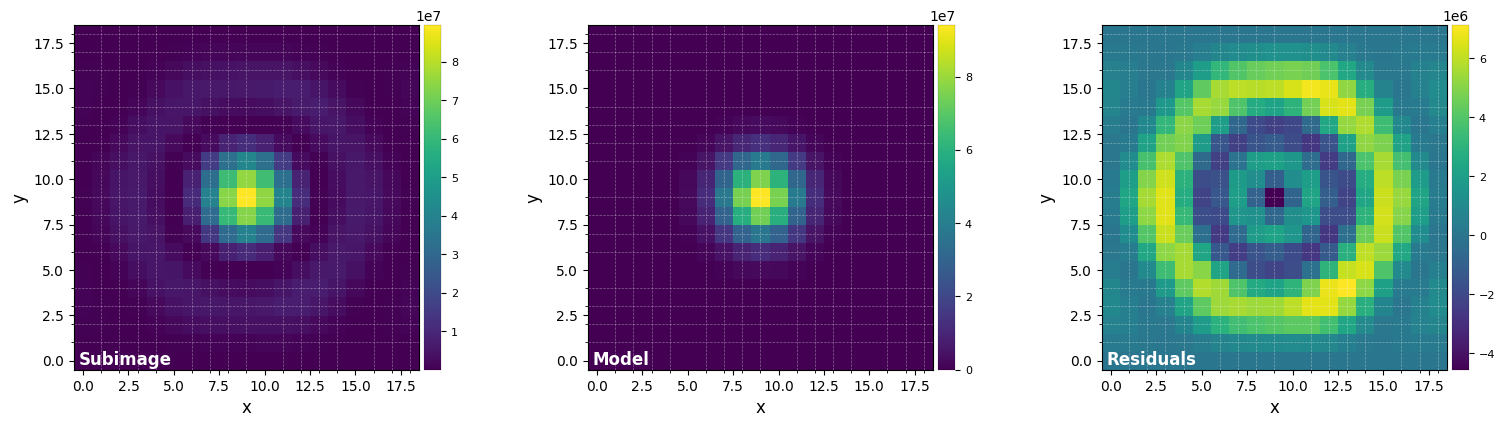

FWHM_y = 3.5005910157512905
FWHM_x = 3.4949576439253818 

centroid y = 9.028970055841148
centroid x = 9.00926627539722
centroid y subim = 9.028970055841148
centroid x subim = 9.00926627539722 

amplitude = 94212111.1613018
theta = 4.954443802703337

Mean FWHM: 3.498
Flux in 1xFWHM aperture: 640483653.378


In [4]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

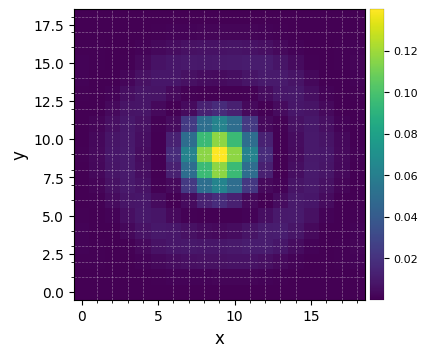

In [5]:
plot_frames(psfn, grid=True, size_factor=4)

In [6]:
from vip_hci.preproc.subsampling import cube_subsample

# make a subsample of 100 images of each of the reference cube files and combine them to one large cube of 2400 images
mags = [7.0,7.5,8.0,8.5]
seeing = ['smedian', 'sQ2', 'sQ3']
versions = ['v1', 'v2']
cube_ref = 1
for mag in mags:
     for see in seeing:
         for ver in versions:
            cube_ref_cur = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_{}_z30d_Kmag{}_{}.fits".format(see, mag, ver)
            cube_ref_cur = open_fits(cube_ref_cur)
            cube_ref_cur = cube_subsample(cube_ref_cur,60)
            if type(cube_ref) == int:
                cube_ref = cube_ref_cur
            else:
                cube_ref = np.concatenate((cube_ref, cube_ref_cur))
print(cube_ref.shape)

FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (60

In [7]:
from vip_hci.preproc import cube_detect_badfr_correlation
from vip_hci.preproc.subsampling import cube_subsample
good_list = []
# find the mostly correlated images from the 2400 image reference cube, not sure if this is the best way to do this as the numbers dont vastly change, feel like we should either pick subsampling or getting the best correlation
for frame in cube_subsample(cube,60):
    good_idx_p, bad_idx_p = cube_detect_badfr_correlation(cube_ref, frame_ref=frame, 
                                                        crop_size=31, dist='pearson', percentile=99, 
                                                        threshold=None, plot=False, verbose=False)
    good_list += list(good_idx_p)
good_list = list(dict.fromkeys(good_list))
print(len(good_list))

Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
929


In [8]:
print(len(good_list))
cube_ref_trim = np.zeros(shape = (len(good_list), 293, 293))
for i in range(len(good_list)):
    cube_ref_trim[i] = cube_ref[good_list[i]]

929


Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-12 17:21:41
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 33.413 GB
System available memory = 17.788 GB
Done vectorizing the frames. Matrix shape: (100, 85849)
Done vectorizing the frames. Matrix shape: (929, 85849)
Done SVD/PCA with randomized SVD
Running time:  0:00:00.459139
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:33.449287
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


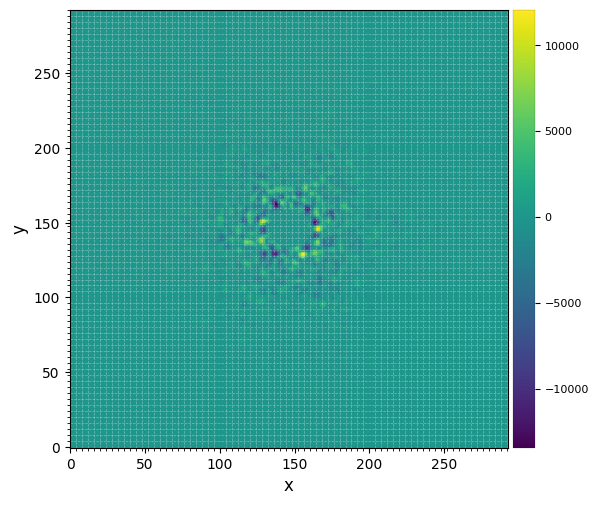

In [9]:
from vip_hci.psfsub import pca
from vip_hci.config.paramenum import SvdMode
SvdMode.CUPY
angs = np.zeros(shape = 100)
cube_sampled = cube_subsample(cube,60)
pca_rdi_fr = pca(cube_sampled, angs, ncomp=42, cube_ref=cube_ref_trim, svd_mode = SvdMode.RANDSVD)
from vip_hci.var import mask_circle
plot_frames(mask_circle(pca_rdi_fr, 13), grid=True)

In [10]:
starphot = float(flux)
print(starphot)

640483653.3776765


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-12 18:04:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.497774329838336, # BRANCHES = 3, SIGMA = 5, STARPHOT = 640483653.3776765
Finished the throughput calculation
Running time:  0:05:38.628351
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


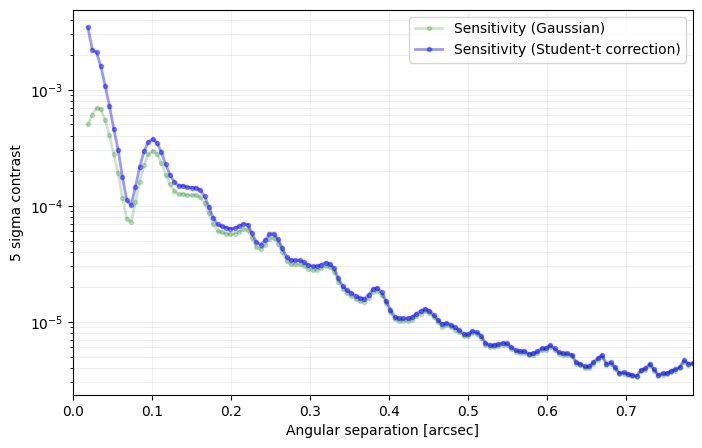

In [14]:
from vip_hci.metrics import contrast_curve
pxscale = 0.00547 # arcseconds/pixel
cc_rdi = contrast_curve(cube_sampled, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=10, cube_ref=cube_ref_trim, svd_mode = SvdMode.RANDSVD, save_plot = "C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP")

In [23]:
import pandas as pd
cc_rdi.to_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_median_sci100_ref2400_cor.pkl')

0        3.497774
1        4.497774
2        5.497774
3        6.497774
4        7.497774
          ...    
136    139.497774
137    140.497774
138    141.497774
139    142.497774
140    143.497774
Name: distance, Length: 141, dtype: float64

In [42]:
from vip_hci.preproc.subsampling import cube_subsample
from vip_hci.fits import open_fits
import numpy as np

# make a subsample of 100 images of each of the reference cube files and combine them to one large cube of 2400 images
mags = [7.0,7.5,8.0,8.5]
seeing = ['smedian', 'sQ2', 'sQ3']
versions = ['v1', 'v2']
cube_ref = 1
for mag in mags:
     for see in seeing:
         for ver in versions:
            cube_ref_cur = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_{}_z30d_Kmag{}_{}.fits".format(see, mag, ver)
            if cube_ref_cur == "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag9.0_v2.fits":
                pass
            else:
                cube_ref_cur = open_fits(cube_ref_cur)
                cube_ref_cur = cube_subsample(cube_ref_cur,60)
                if type(cube_ref) == int:
                    cube_ref = cube_ref_cur
                else:
                    cube_ref = np.concatenate((cube_ref, cube_ref_cur))
print(cube_ref.shape)

FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (60

In [48]:
from vip_hci.preproc.subsampling import cube_subsample
from vip_hci.fits import open_fits
import numpy as n

# alternatively, for local files simply provide their full or relative path. E.g.:
f1 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag8.0_v2.fits"
f2 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/offaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag8.0_v2.fits"

cube = open_fits(f1)
psf = open_fits(f2)

cube_ref = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag8.0_v2.fits"
cube_ref = open_fits(cube_ref)

FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)


In [52]:

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag7.0_v2.fits"
#f2 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/offaxis_PSF_L_CVC_with_bkg_smedian_z30d_Kmag7.0_v2.fits"

#cube = open_fits(f1)
#psf = open_fits(f2)

from vip_hci.preproc import cube_detect_badfr_correlation
from vip_hci.preproc.subsampling import cube_subsample
good_list = []
prog = 0
# find the mostly correlated images from the 2400 image reference cube, not sure if this is the best way to do this as the numbers dont vastly change, feel like we should either pick subsampling or getting the best correlation
for frame in cube_subsample(cube,60):
    good_idx_p, bad_idx_p = cube_detect_badfr_correlation(cube_ref, frame_ref=frame, 
                                                        crop_size=31, dist='pearson', percentile=1, 
                                                        threshold=None, plot=False, verbose=False)
    good_list += list(good_idx_p)
    prog += 1
    print('Finished {}/100'.format(prog))
good_list = list(dict.fromkeys(good_list))
print(len(good_list))

cube_ref_trim = np.zeros(shape = (len(good_list), 293, 293))
for i in range(len(good_list)):
    cube_ref_trim[i] = cube_ref[good_list[i]]
print(good_list)

Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
Finished 1/100
Finished 2/100
Finished 3/100
Finished 4/100
Finished 5/100
Finished 6/100
Finished 7/100
Finished 8/100
Finished 9/100
Finished 10/100
Finished 11/100
Finished 12/100
Finished 13/100
Finished 14/100
Finished 15/100
Finished 16/100
Finished 17/100
Finished 18/100
Finished 19/100
Finished 20/100
Finished 21/100
Finished 22/100
Finished 23/100
Finished 24/100
Finished 25/100
Finished 26/100
Finished 27/100
Finished 28/100
Finished 29/100
Finished 30/100
Finished 31/100
Finished 32/100
Finished 33/100
Finished 34/100
Finished 35/100
Finished 36/100
Finished 37/100
Finished 38/100
Finished 39/100
Finished 40/100
Finished 41/100
Finished 42/100
Finished 43/100
Finished 44/100
Finished 45/100
Finished 46/100
Finished 47/100
Finished 48/100
Finished 49/100
Finished 50/100
Finished 51/100
Finished 52/100
Finished 53/100
Finished 54/100
Finished 55/100
Finished 56/100
Finished 57/100
Finis

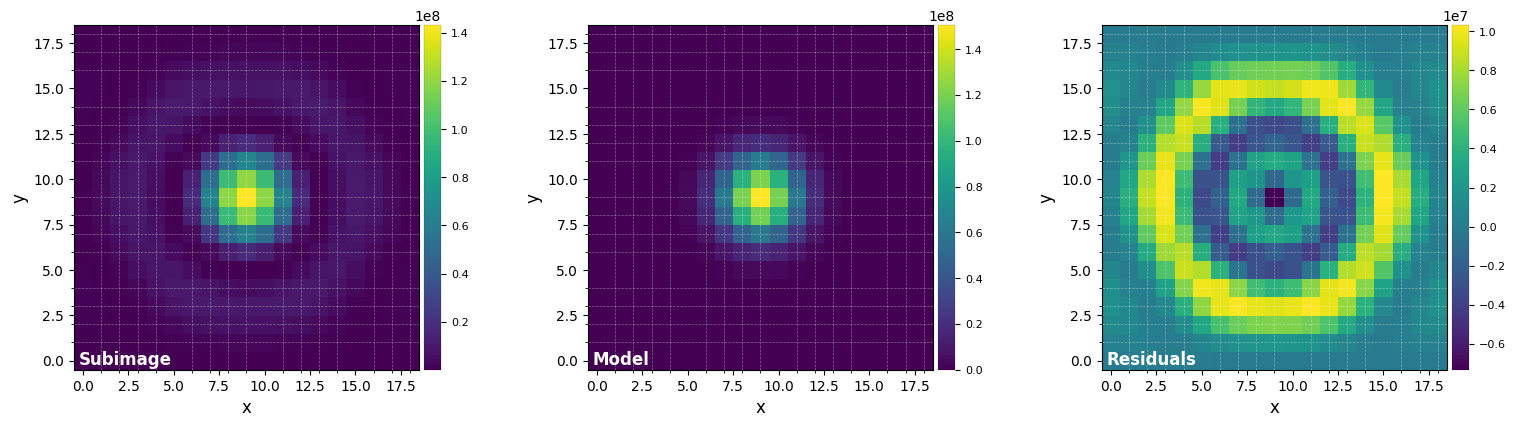

FWHM_y = 3.4919008889427867
FWHM_x = 3.495509724690606 

centroid y = 9.016738063652822
centroid x = 8.999479381614885
centroid y subim = 9.016738063652822
centroid x subim = 8.999479381614885 

amplitude = 150732497.94074792
theta = -30.248749240121544

Mean FWHM: 3.494
Flux in 1xFWHM aperture: 1022376054.889
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-19 17:50:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4937053068166963, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1022376054.888767
Finished the throughput calculation
Running time:  0:05:57.699145
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


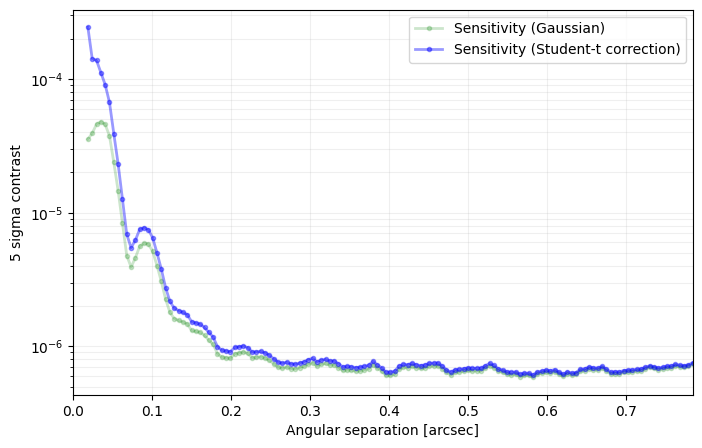

In [53]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version
from vip_hci.fits import open_fits
from astropy.utils.data import download_file
from vip_hci.psfsub import pca
from vip_hci.config.paramenum import SvdMode

from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

cube_sampled = cube_subsample(cube,60)
angs = np.zeros(shape = 100) # should be the same length as cube_sampled
starphot = float(flux)

from vip_hci.metrics import contrast_curve
pxscale = 0.00547 # arcseconds/pixel
cc_rdi = contrast_curve(cube_sampled, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=10, cube_ref=cube_ref_trim, svd_mode = SvdMode.RANDSVD)

import pandas as pd
cc_rdi.to_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.0_v2_smedian_sci100_ref6000_uncor.pkl') # saving format [mag]_[version]_[seeing]_sci[science sample length]_ref[reference sample length]_[reference cube correlated or not]

FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
Item 1/24 Finished Correlation 1/100
Item 1/24 Finished Correlation 2/100
Item 1/24 Finished Correlation 3/100
Item 1/24 Finished Correlation 4/100
Item 1/24 Finished Correlation 5/100
Item 1/24 Finished Correlation 6/100
Item 1/24 Finished Correlation 7/100
Item 1/24 Finished Correlation 8/100
Item 1/24 Finished Correlation 9/100
Item 1/24 Finished Correlation 10/100
Item 1/24 Finished Correlation 11/100
Item 1/24 Finished Correlation 12/100
Item 1/24 Finished Correlation 13/100
Item 1/24 Finished Correlation 14/100
Item 1/24 Finished Correlation 15/100
Item 1/24 Finished Correlation 16/100
Item 1/24 Finished Correlation 17/100
Item 1/24 Finished Correlation 18/100
Item 1/24 Finished Correlation 19/100
Item 1/24 Finished Correlation 20/100
Item 1/24 Finished Correlation 

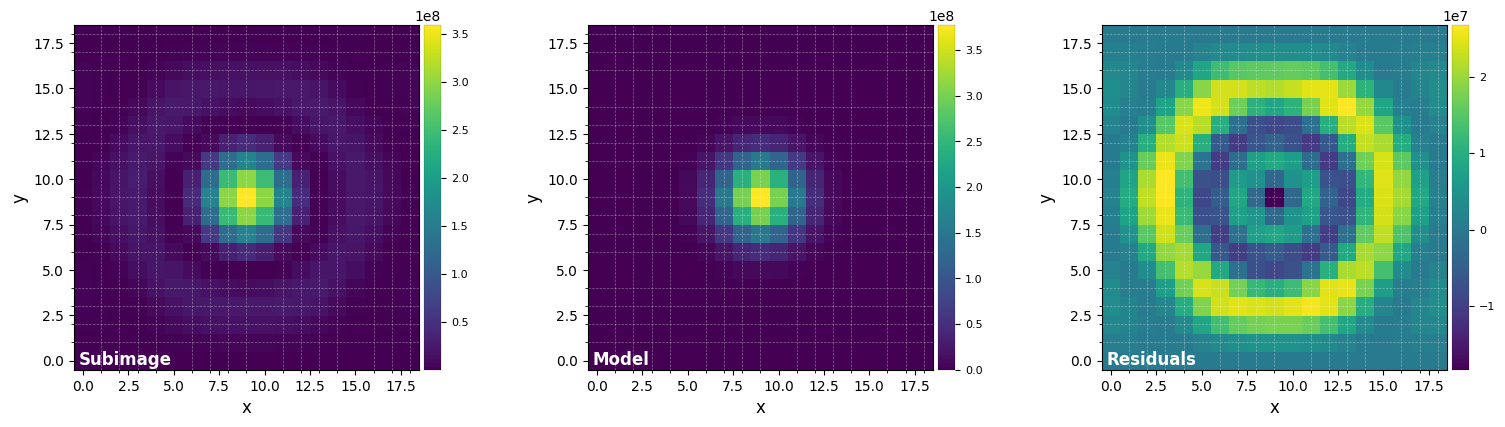

FWHM_y = 3.48915959263664
FWHM_x = 3.4952709761708243 

centroid y = 9.008626066454909
centroid x = 9.004809310762479
centroid y subim = 9.008626066454909
centroid x subim = 9.004809310762479 

amplitude = 377380640.7645961
theta = 30.494247597486087

Mean FWHM: 3.492
Flux in 1xFWHM aperture: 2557722071.095
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 17:44:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4922152844037324, # BRANCHES = 3, SIGMA = 5, STARPHOT = 2557722071.0949497
Finished the throughput calculation
Running time:  0:05:56.670953
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by tak

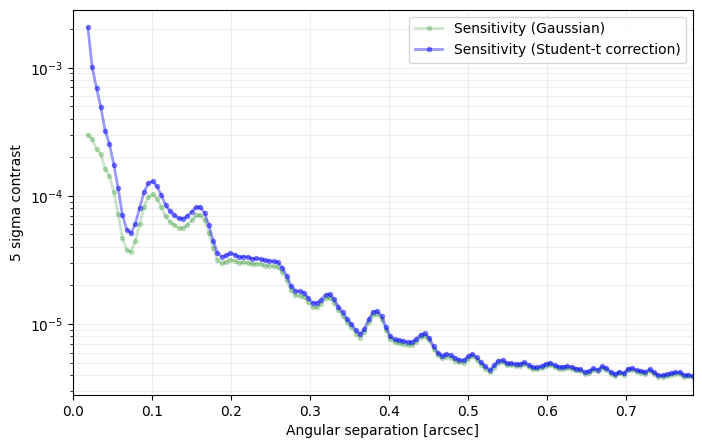

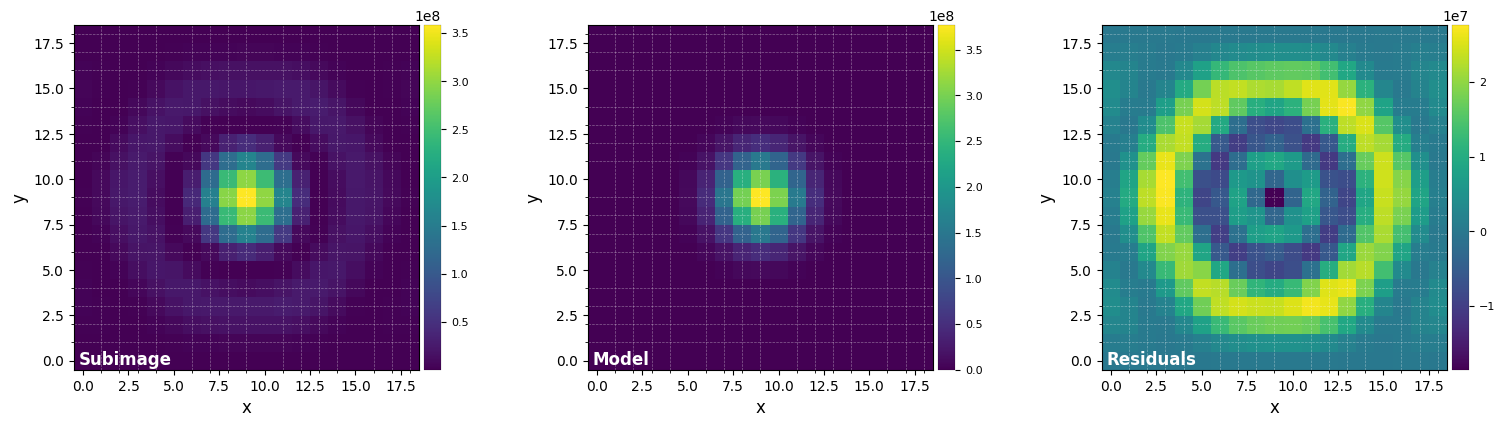

FWHM_y = 3.4894927272451786
FWHM_x = 3.4812225546452944 

centroid y = 9.005040463481127
centroid x = 9.016812115803937
centroid y subim = 9.005040463481127
centroid x subim = 9.016812115803937 

amplitude = 377173471.1711034
theta = -14.43652371237934

Mean FWHM: 3.485
Flux in 1xFWHM aperture: 2546427998.734
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 17:52:03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4853576409452365, # BRANCHES = 3, SIGMA = 5, STARPHOT = 2546427998.7339244
Finished the throughput calculation
Running time:  0:05:57.517725
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by t

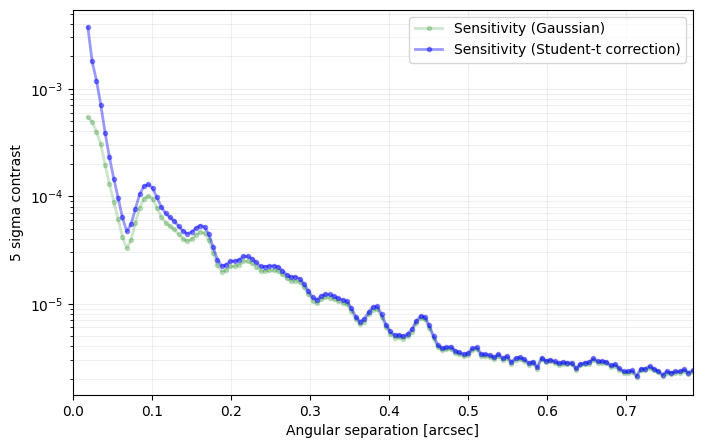

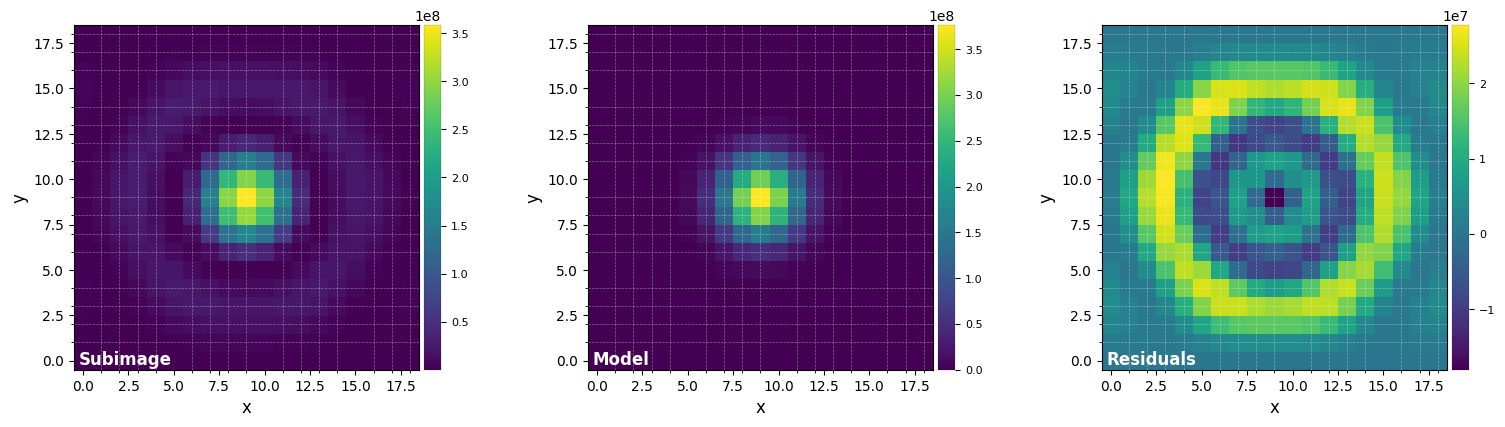

FWHM_y = 3.5100806873444816
FWHM_x = 3.4847101459804306 

centroid y = 8.956020400138415
centroid x = 9.017505834747686
centroid y subim = 8.956020400138415
centroid x subim = 9.017505834747686 

amplitude = 376982947.99124473
theta = -29.9209802894656

Mean FWHM: 3.497
Flux in 1xFWHM aperture: 2562541638.585
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 17:59:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.497395416662456, # BRANCHES = 3, SIGMA = 5, STARPHOT = 2562541638.584871
Finished the throughput calculation
Running time:  0:05:54.948299
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by tak

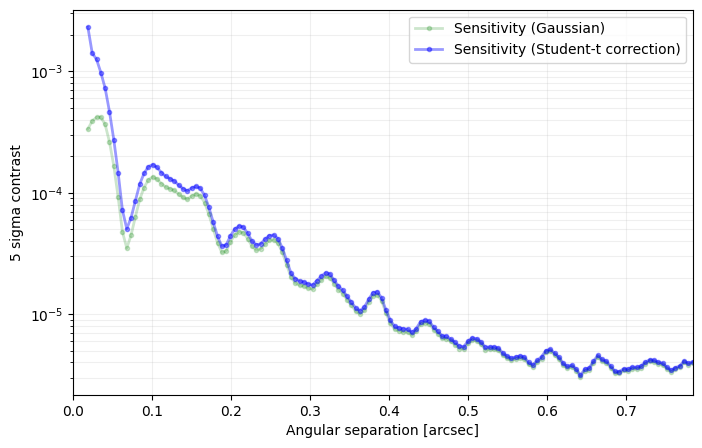

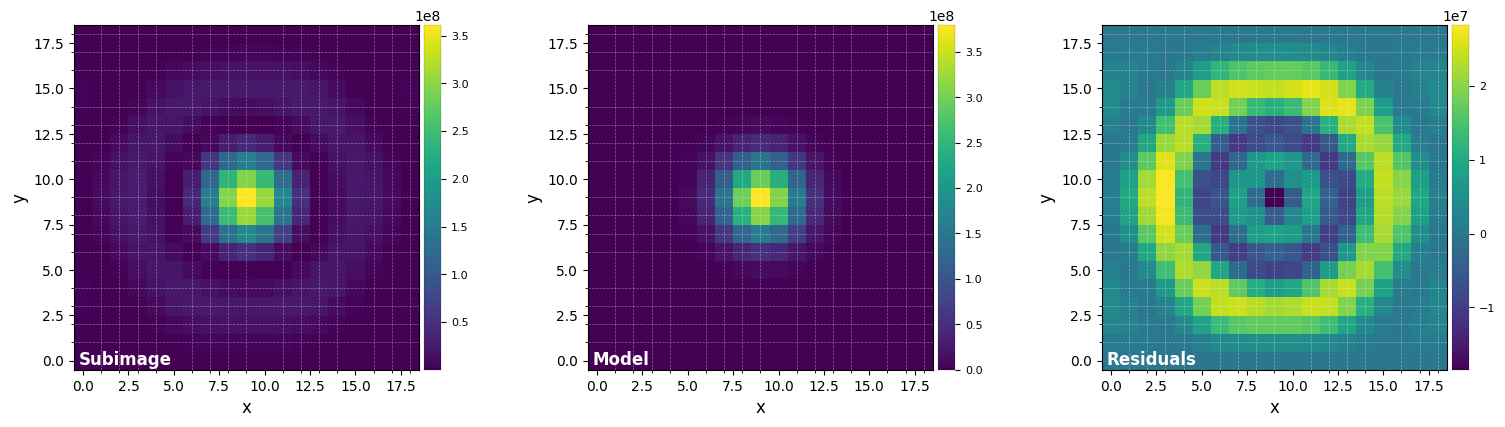

FWHM_y = 3.5055468389967364
FWHM_x = 3.4826355450230353 

centroid y = 8.944146396865053
centroid x = 9.04942203499032
centroid y subim = 8.944146396865053
centroid x subim = 9.04942203499032 

amplitude = 380191076.8904013
theta = -129.39846540672156

Mean FWHM: 3.494
Flux in 1xFWHM aperture: 2577116916.308
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 18:07:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.494091192009886, # BRANCHES = 3, SIGMA = 5, STARPHOT = 2577116916.308379
Finished the throughput calculation
Running time:  0:05:58.076996
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taki

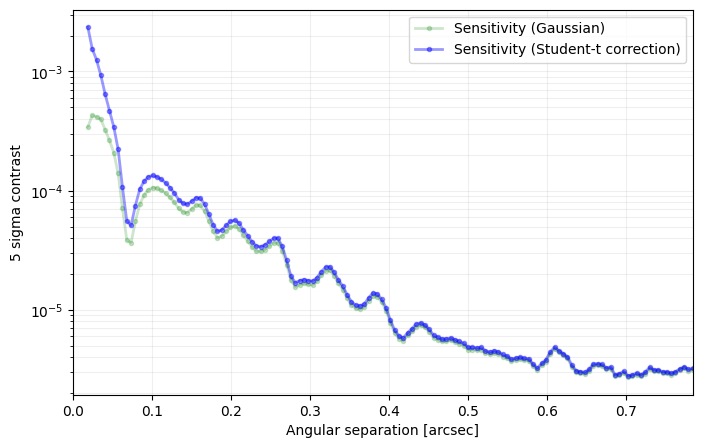

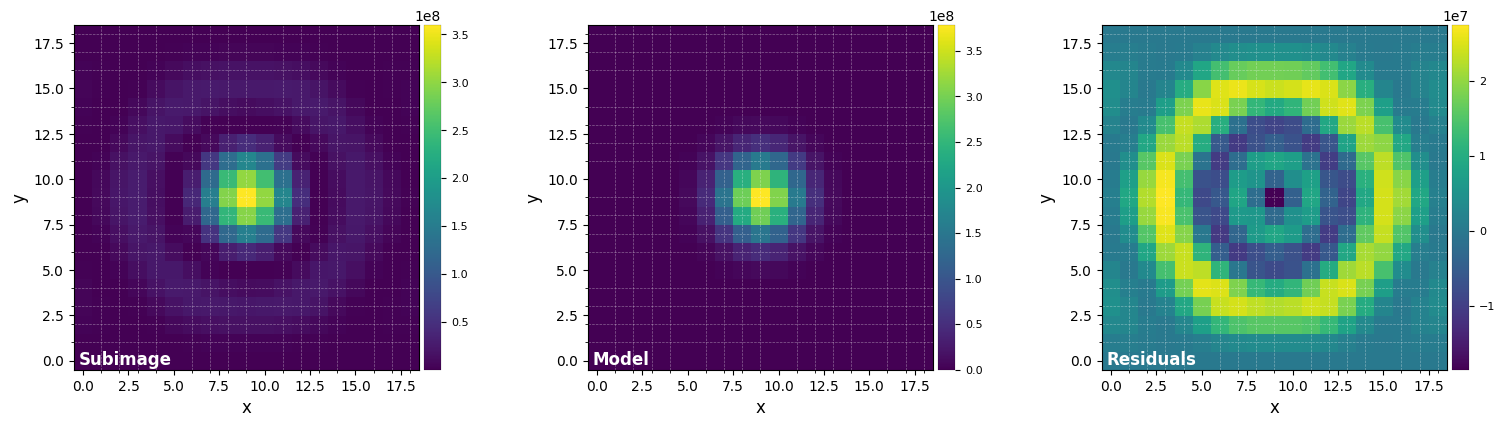

FWHM_y = 3.4814576148010485
FWHM_x = 3.4714159424410553 

centroid y = 9.032804294648452
centroid x = 9.037796059824064
centroid y subim = 9.032804294648452
centroid x subim = 9.037796059824064 

amplitude = 378791033.6067204
theta = 29.793584434338406

Mean FWHM: 3.476
Flux in 1xFWHM aperture: 2545141100.321
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 18:15:35
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4764367786210517, # BRANCHES = 3, SIGMA = 5, STARPHOT = 2545141100.321034
Finished the throughput calculation
Running time:  0:05:57.405764
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by ta

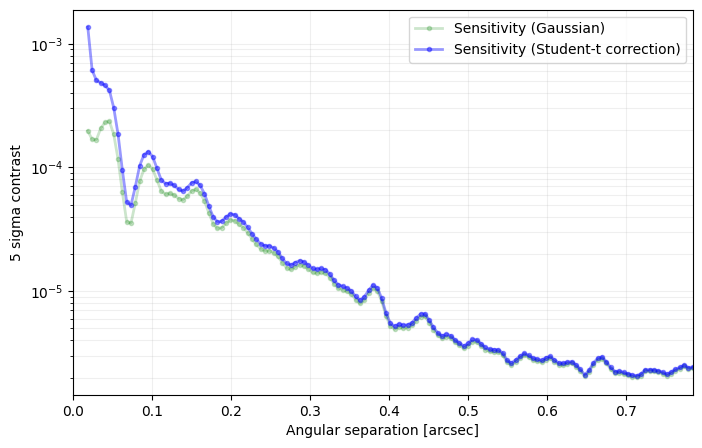

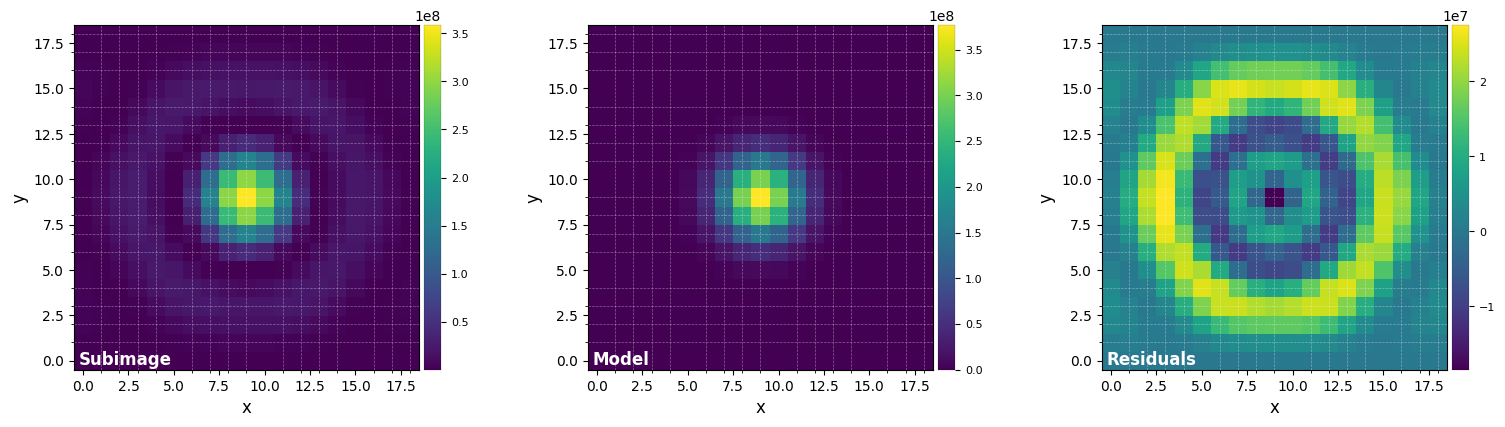

FWHM_y = 3.500112465411793
FWHM_x = 3.495505657389622 

centroid y = 9.004721067361622
centroid x = 9.009360748841559
centroid y subim = 9.004721067361622
centroid x subim = 9.009360748841559 

amplitude = 377242489.9239925
theta = -152.13741947647995

Mean FWHM: 3.498
Flux in 1xFWHM aperture: 2564406625.071
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 18:23:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.497809061400708, # BRANCHES = 3, SIGMA = 5, STARPHOT = 2564406625.0707197
Finished the throughput calculation
Running time:  0:05:58.536880
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by tak

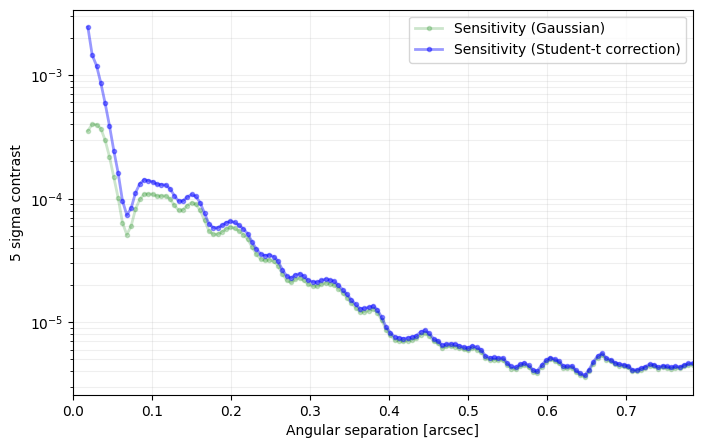

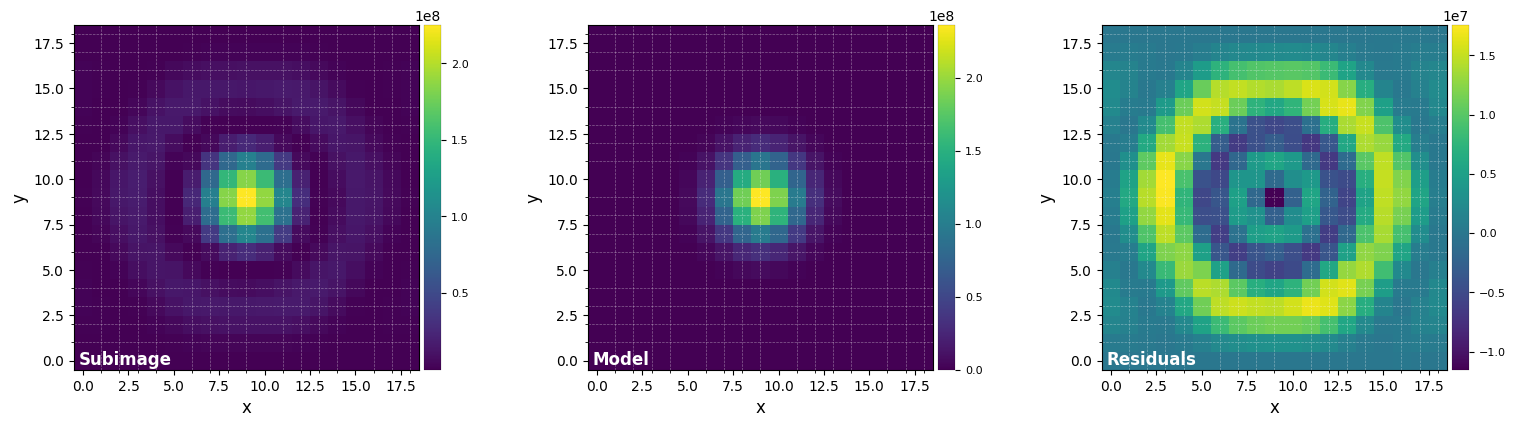

FWHM_y = 3.47752824411696
FWHM_x = 3.500125995325908 

centroid y = 8.967070702948178
centroid x = 9.03165092837923
centroid y subim = 8.967070702948178
centroid x subim = 9.03165092837923 

amplitude = 236652878.76236227
theta = 222.14486022568082

Mean FWHM: 3.489
Flux in 1xFWHM aperture: 1600392081.424
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 18:31:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4888271197214342, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1600392081.4240086
Finished the throughput calculation
Running time:  0:05:57.123591
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by takin

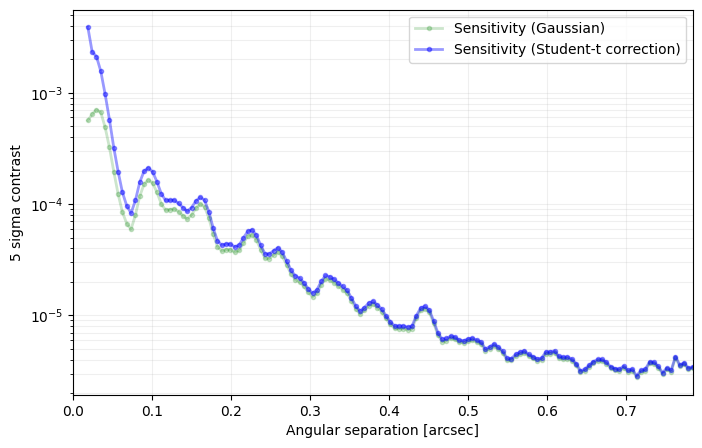

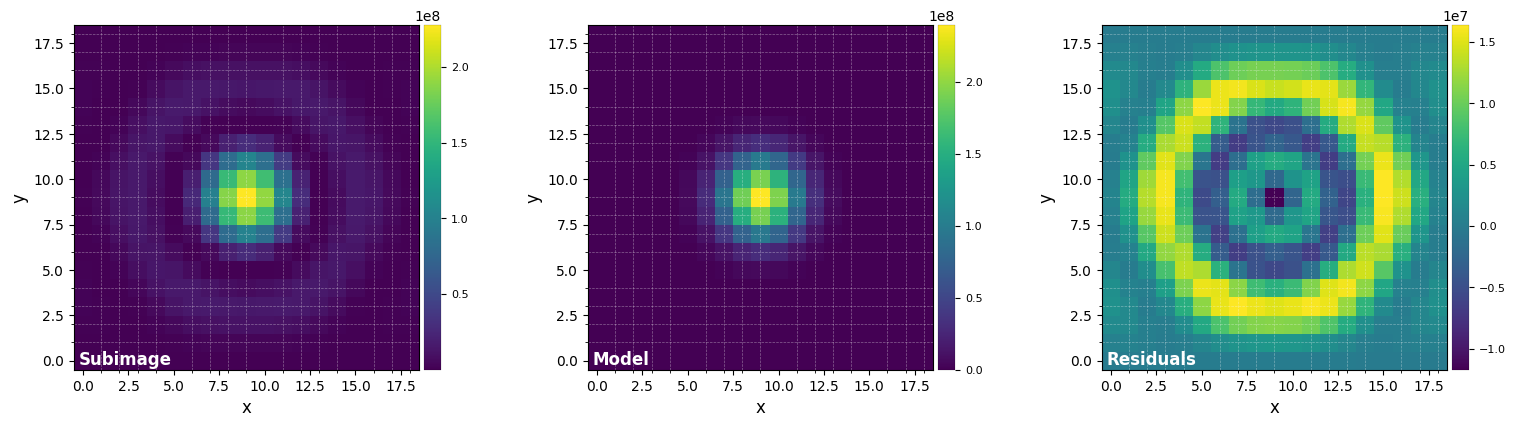

FWHM_y = 3.4997056703370517
FWHM_x = 3.485551026847743 

centroid y = 9.007106600401363
centroid x = 9.031487003034442
centroid y subim = 9.007106600401363
centroid x subim = 9.031487003034442 

amplitude = 239571424.85160977
theta = -23.914515942185126

Mean FWHM: 3.493
Flux in 1xFWHM aperture: 1623688182.454
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 18:39:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4926283485923975, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1623688182.4537067
Finished the throughput calculation
Running time:  0:05:58.041362
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by 

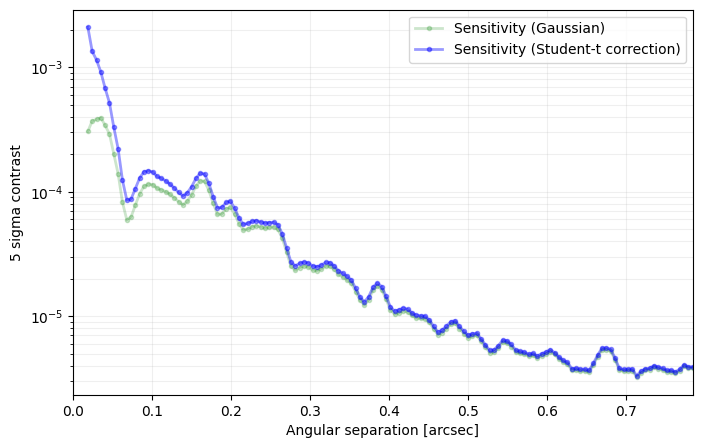

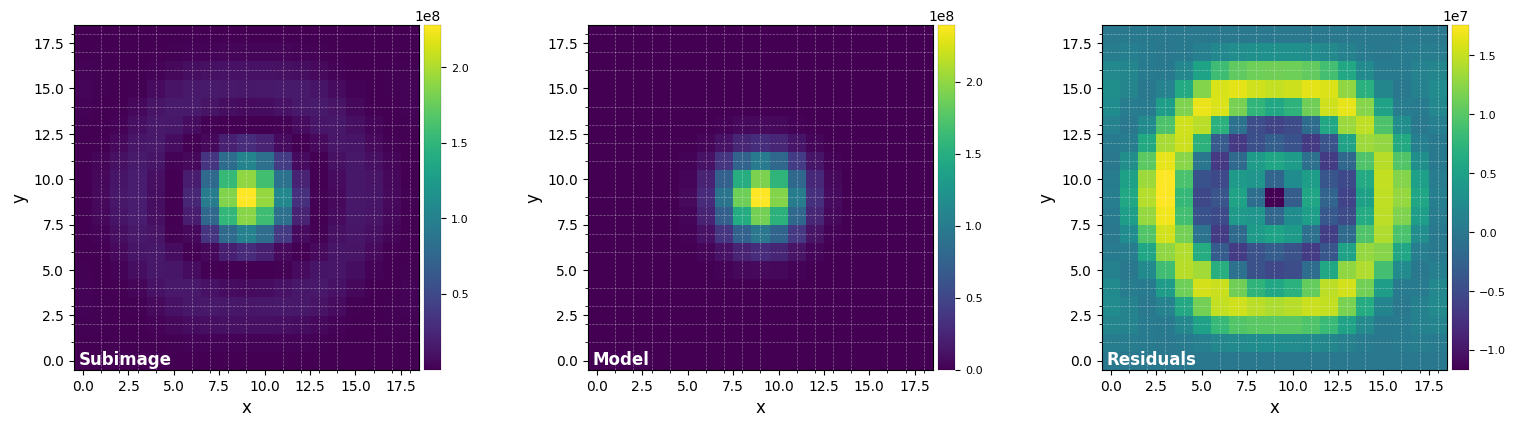

FWHM_y = 3.4916297687853666
FWHM_x = 3.484541051415875 

centroid y = 9.014283301442006
centroid x = 9.051293227855181
centroid y subim = 9.014283301442006
centroid x subim = 9.051293227855181 

amplitude = 239823572.45988932
theta = -22.43488882465841

Mean FWHM: 3.488
Flux in 1xFWHM aperture: 1621699415.975
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 18:46:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.488085410100621, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1621699415.9747233
Finished the throughput calculation
Running time:  0:05:57.786570
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by ta

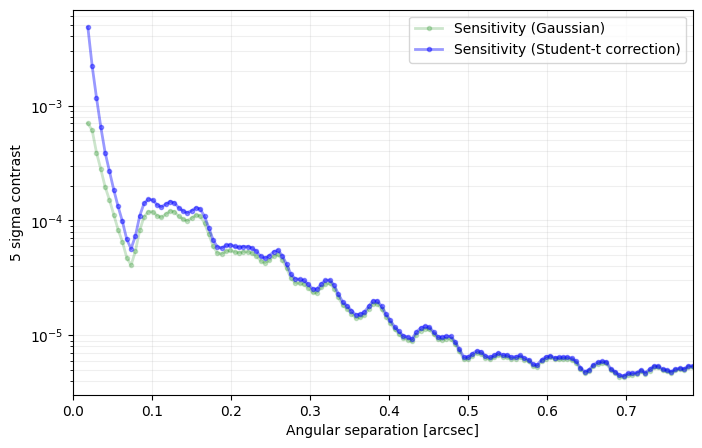

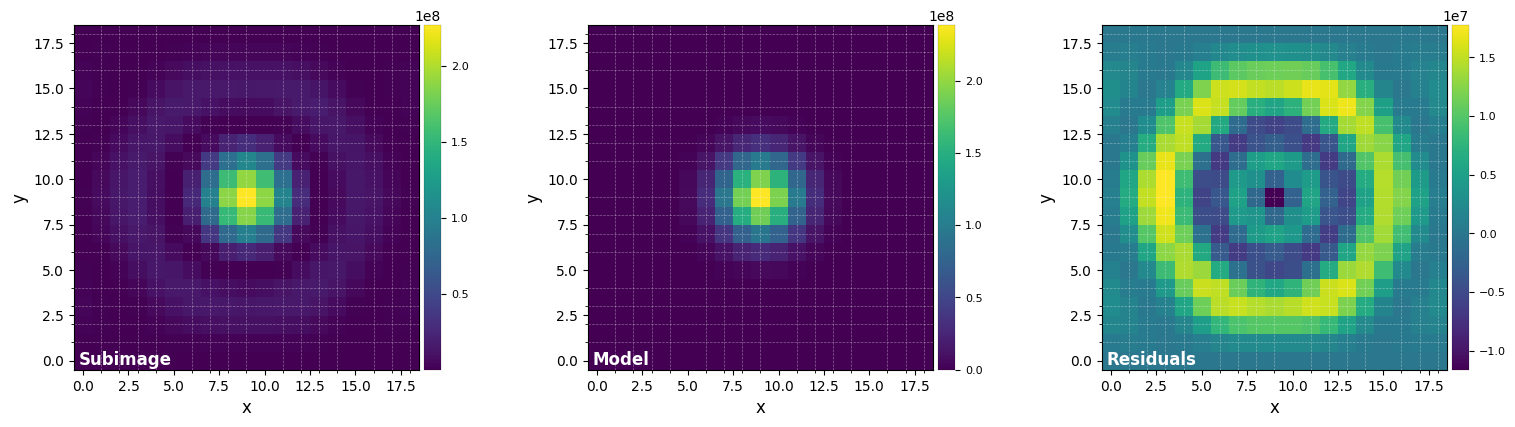

FWHM_y = 3.486194597293959
FWHM_x = 3.491428291683203 

centroid y = 9.032713007298213
centroid x = 9.012229957085168
centroid y subim = 9.032713007298213
centroid x subim = 9.012229957085168 

amplitude = 238571368.6940729
theta = -32.96917027444463

Mean FWHM: 3.489
Flux in 1xFWHM aperture: 1613903369.600
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 18:54:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.488811444488581, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1613903369.6002982
Finished the throughput calculation
Running time:  0:05:57.427199
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taki

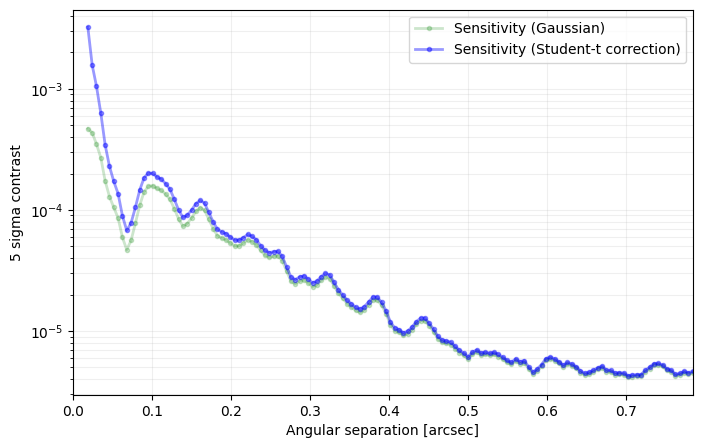

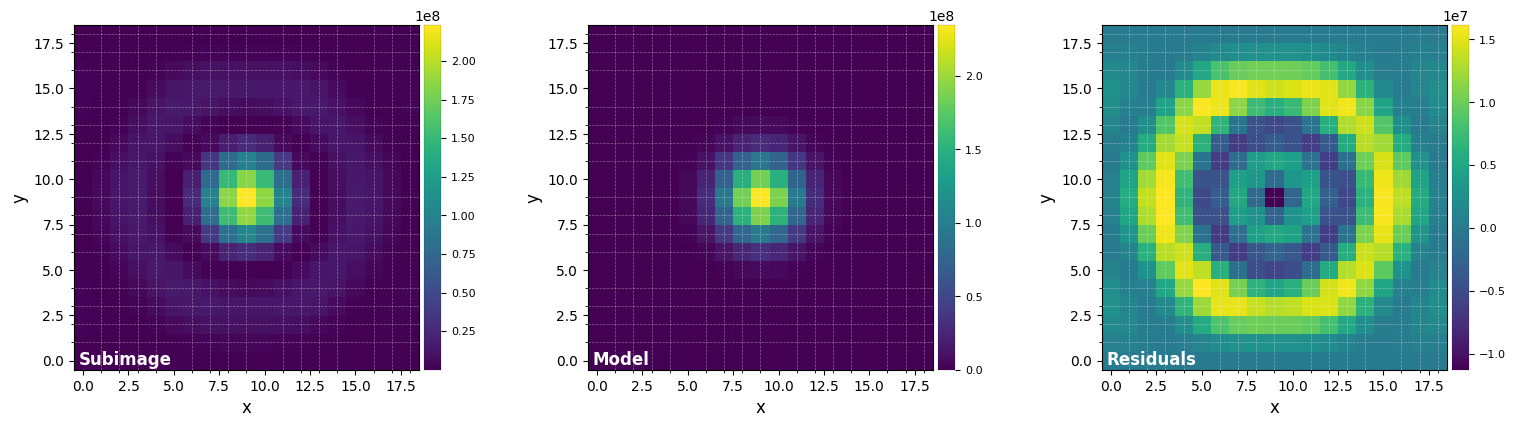

FWHM_y = 3.505986395246909
FWHM_x = 3.4948739782243665 

centroid y = 8.976699866732897
centroid x = 9.011852643140049
centroid y subim = 8.976699866732897
centroid x subim = 9.011852643140049 

amplitude = 234627084.3625612
theta = -12.83737901061228

Mean FWHM: 3.500
Flux in 1xFWHM aperture: 1597506485.127
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:02:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.5004301867356378, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1597506485.1272442
Finished the throughput calculation
Running time:  0:05:58.277912
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by ta

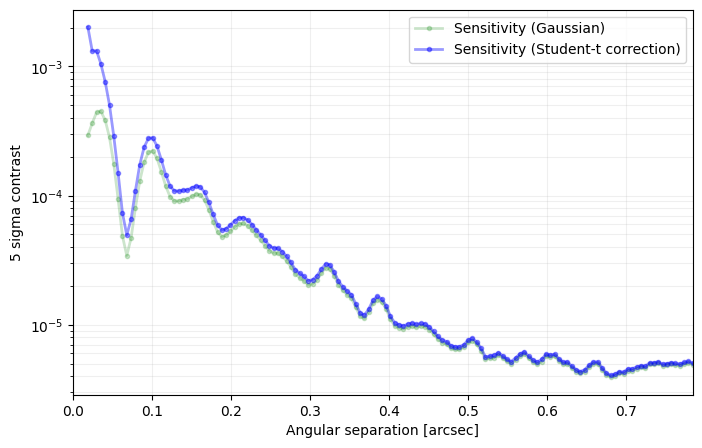

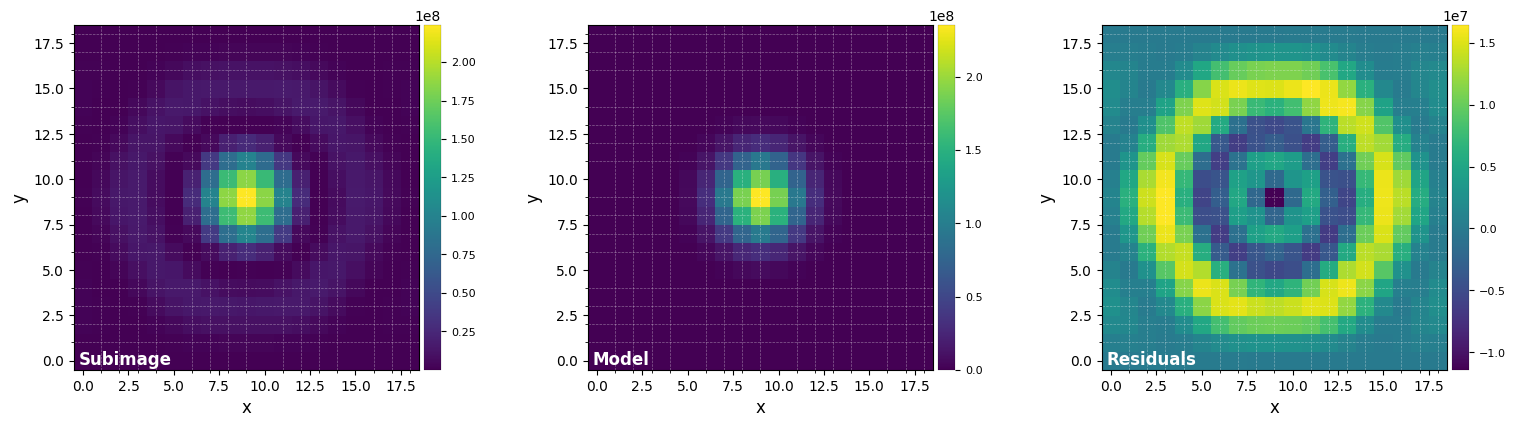

FWHM_y = 3.5039615197144207
FWHM_x = 3.4914907701504854 

centroid y = 8.98763960317886
centroid x = 8.996066599538235
centroid y subim = 8.98763960317886
centroid x subim = 8.996066599538235 

amplitude = 235632153.61642128
theta = 31.972825610093658

Mean FWHM: 3.498
Flux in 1xFWHM aperture: 1601797066.586
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:10:32
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.497726144932453, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1601797066.5861385
Finished the throughput calculation
Running time:  0:05:57.740194
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by tak

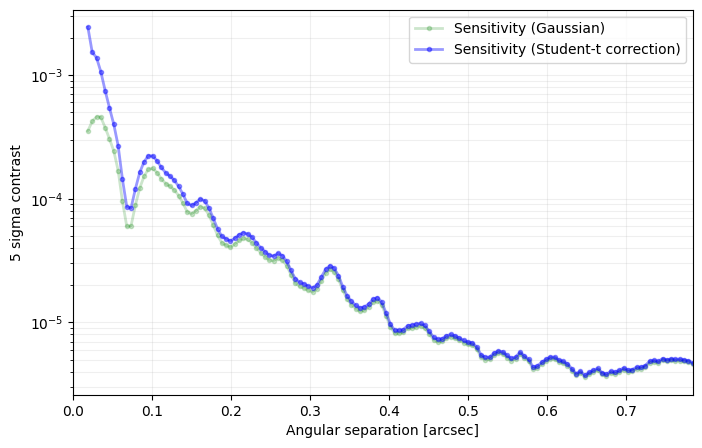

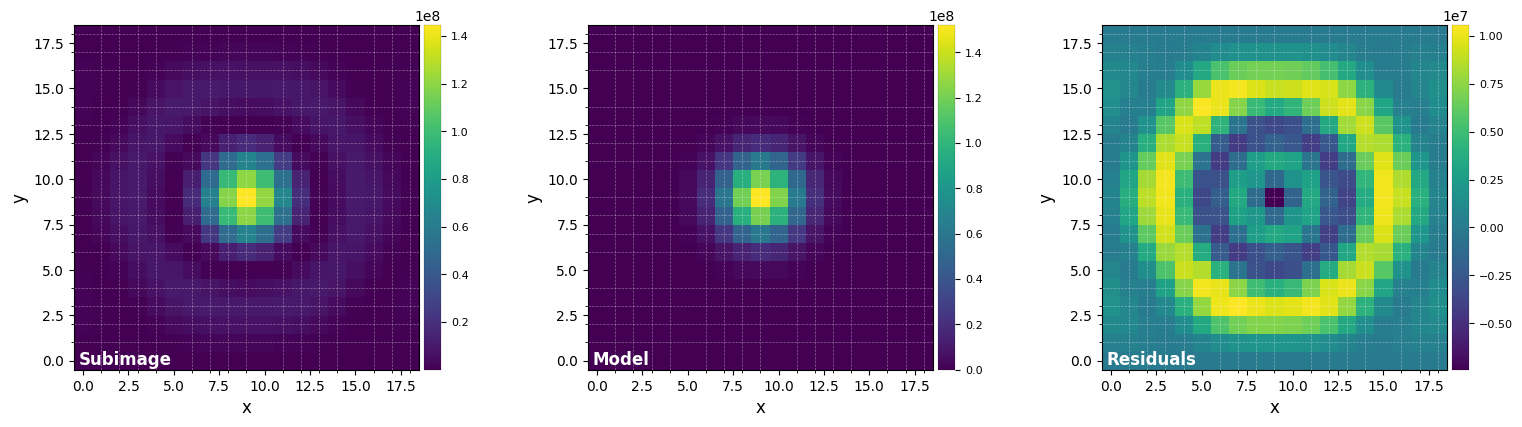

FWHM_y = 3.4907862522347757
FWHM_x = 3.5032829348207013 

centroid y = 9.002170808445602
centroid x = 9.03117485042941
centroid y subim = 9.002170808445602
centroid x subim = 9.03117485042941 

amplitude = 152175678.18192363
theta = 13.403553043249644

Mean FWHM: 3.497
Flux in 1xFWHM aperture: 1033864942.977
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:18:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4970345935277383, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1033864942.9768486
Finished the throughput calculation
Running time:  0:05:57.802346
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by ta

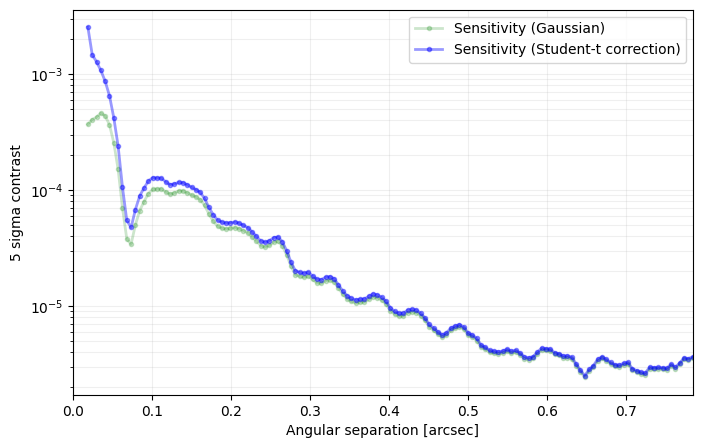

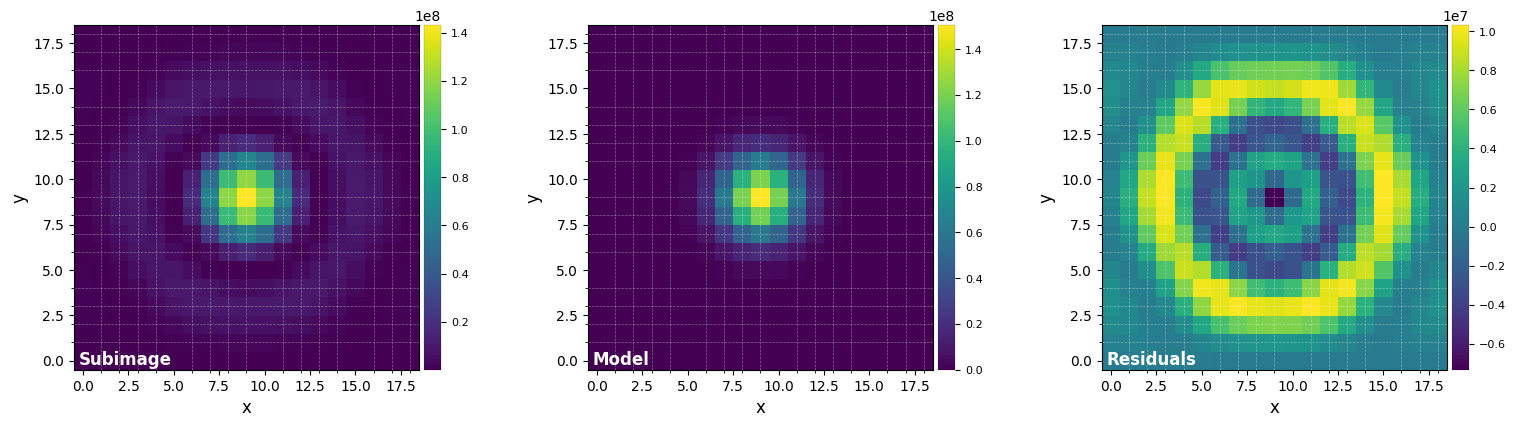

FWHM_y = 3.4919008889427867
FWHM_x = 3.495509724690606 

centroid y = 9.016738063652822
centroid x = 8.999479381614885
centroid y subim = 9.016738063652822
centroid x subim = 8.999479381614885 

amplitude = 150732497.94074792
theta = -30.248749240121544

Mean FWHM: 3.494
Flux in 1xFWHM aperture: 1022376054.889
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:26:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4937053068166963, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1022376054.888767
Finished the throughput calculation
Running time:  0:05:59.740167
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by t

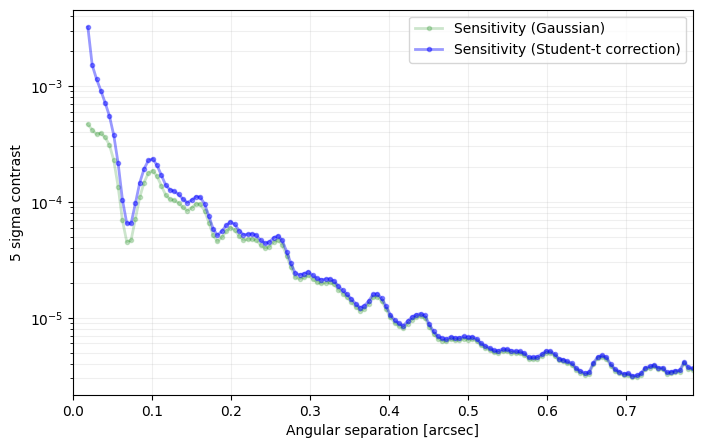

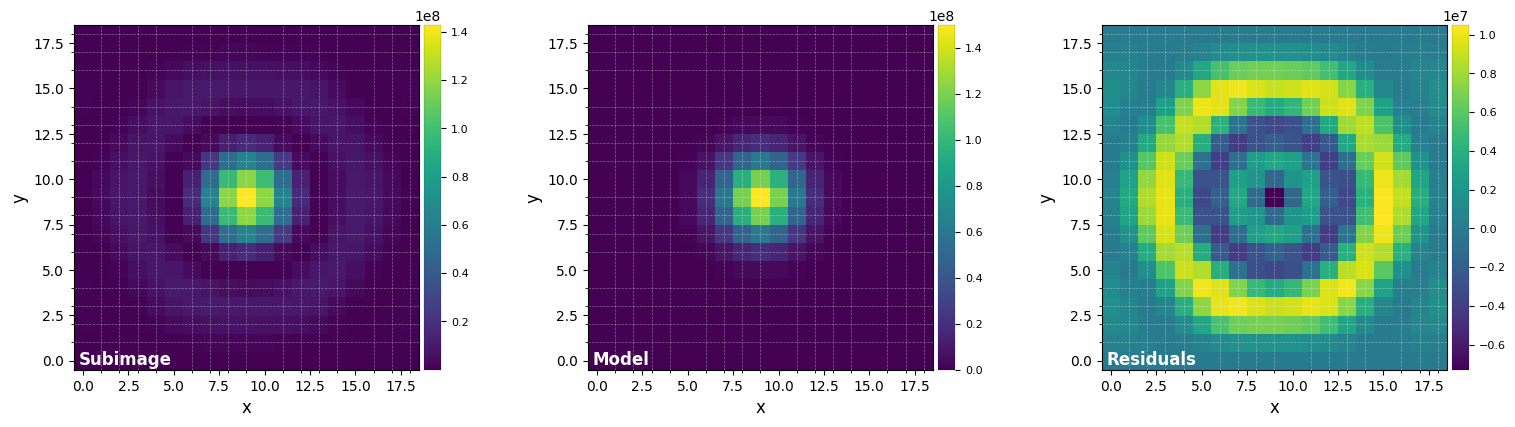

FWHM_y = 3.484368040914036
FWHM_x = 3.497783000553685 

centroid y = 9.000583615148502
centroid x = 9.009731784321998
centroid y subim = 9.000583615148502
centroid x subim = 9.009731784321998 

amplitude = 150154652.8261573
theta = 2025.0702750729815

Mean FWHM: 3.491
Flux in 1xFWHM aperture: 1017039931.645
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:34:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.491075520733861, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1017039931.6449395
Finished the throughput calculation
Running time:  0:05:57.844012
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taki

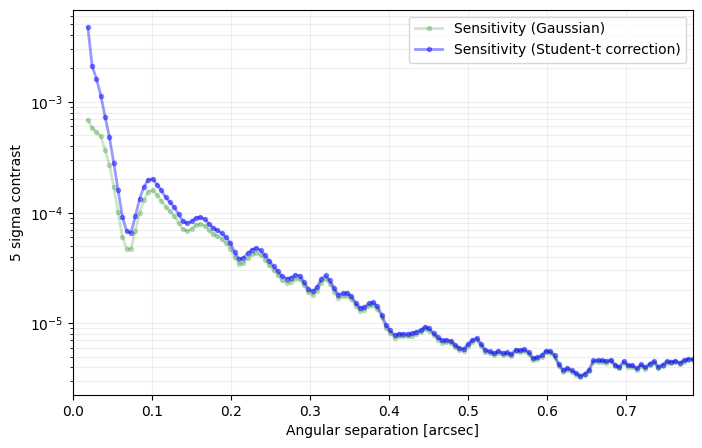

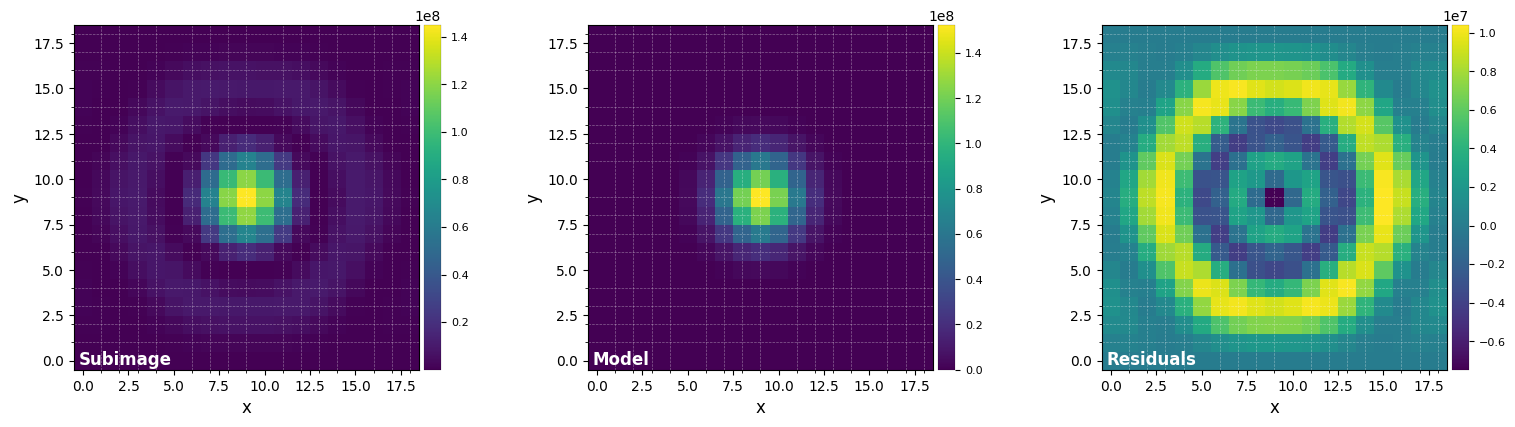

FWHM_y = 3.4998367297799455
FWHM_x = 3.4849054432699664 

centroid y = 8.987633353942089
centroid x = 9.011717019648811
centroid y subim = 8.987633353942089
centroid x subim = 9.011717019648811 

amplitude = 152425605.3089245
theta = -14.130568270328236

Mean FWHM: 3.492
Flux in 1xFWHM aperture: 1032996295.125
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:42:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.492371086524956, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1032996295.1252786
Finished the throughput calculation
Running time:  0:05:57.397986
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by t

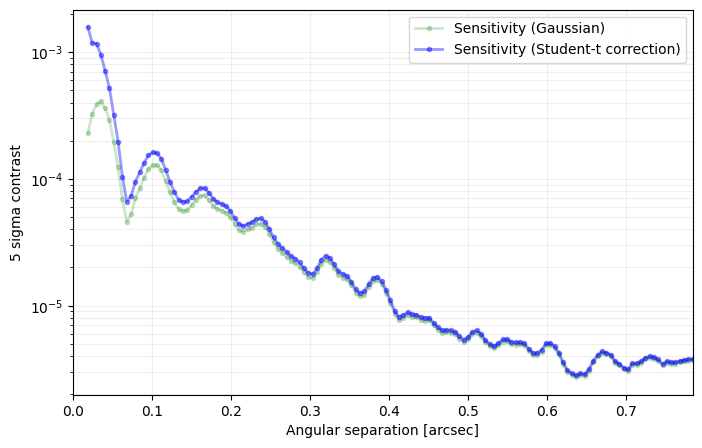

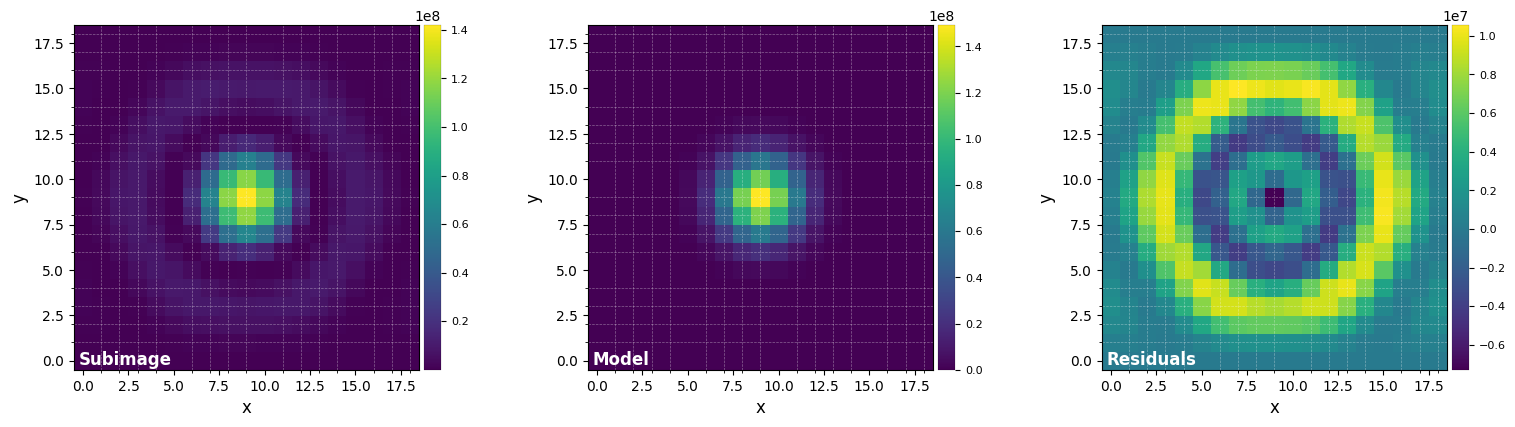

FWHM_y = 3.482304897494904
FWHM_x = 3.493354025014967 

centroid y = 8.974765421539994
centroid x = 9.001359111158546
centroid y subim = 8.974765421539994
centroid x subim = 9.001359111158546 

amplitude = 149377786.68370047
theta = -1755.8758896033369

Mean FWHM: 3.488
Flux in 1xFWHM aperture: 1009940955.734
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:49:52
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.487829461254935, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1009940955.733864
Finished the throughput calculation
Running time:  0:05:58.399712
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by tak

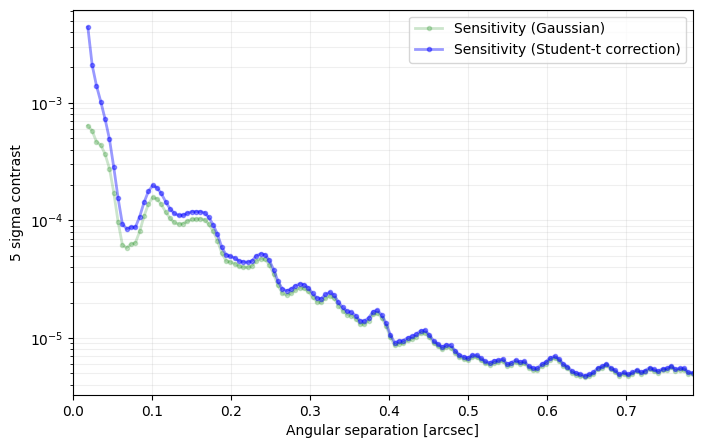

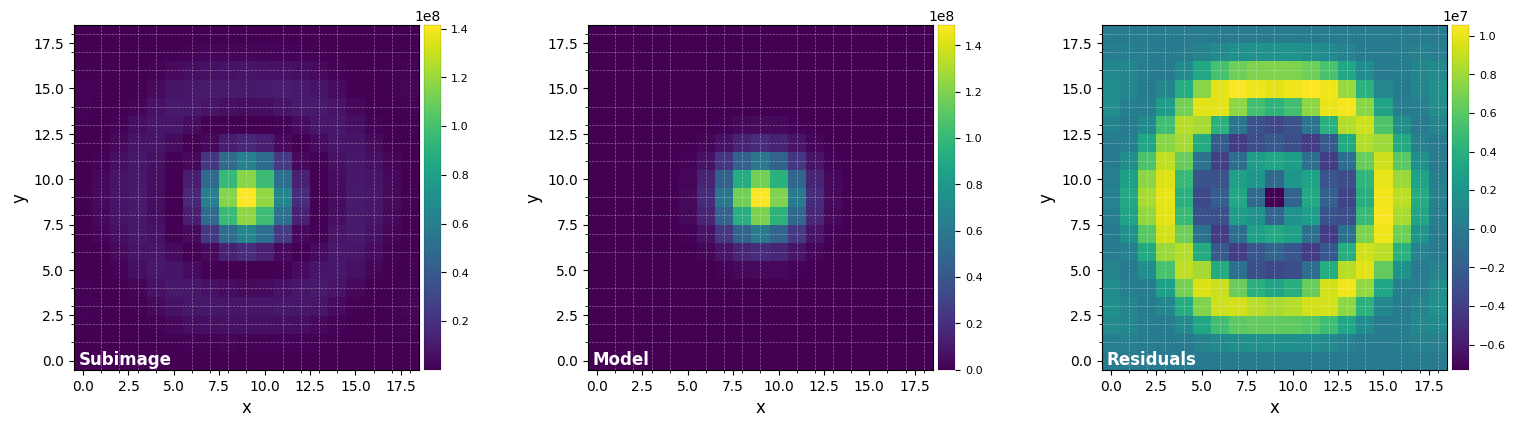

FWHM_y = 3.4870153615276154
FWHM_x = 3.4814573308614576 

centroid y = 8.984545082582427
centroid x = 9.02656228333934
centroid y subim = 8.984545082582427
centroid x subim = 9.02656228333934 

amplitude = 148896867.29773292
theta = -31.114853516858076

Mean FWHM: 3.484
Flux in 1xFWHM aperture: 1004680813.280
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 19:57:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4842363461945363, # BRANCHES = 3, SIGMA = 5, STARPHOT = 1004680813.2803171
Finished the throughput calculation
Running time:  0:05:58.300153
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by t

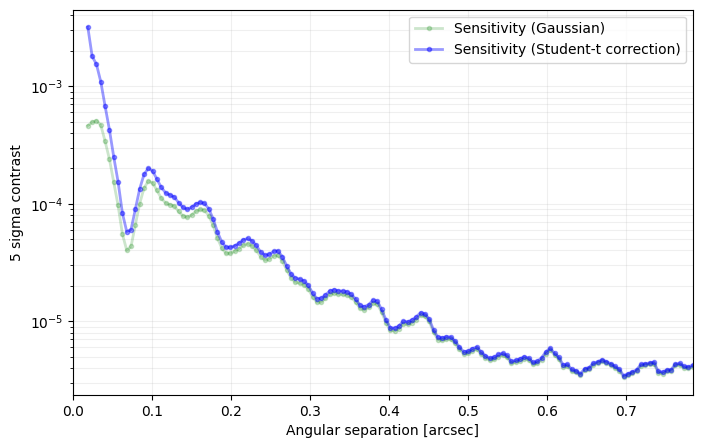

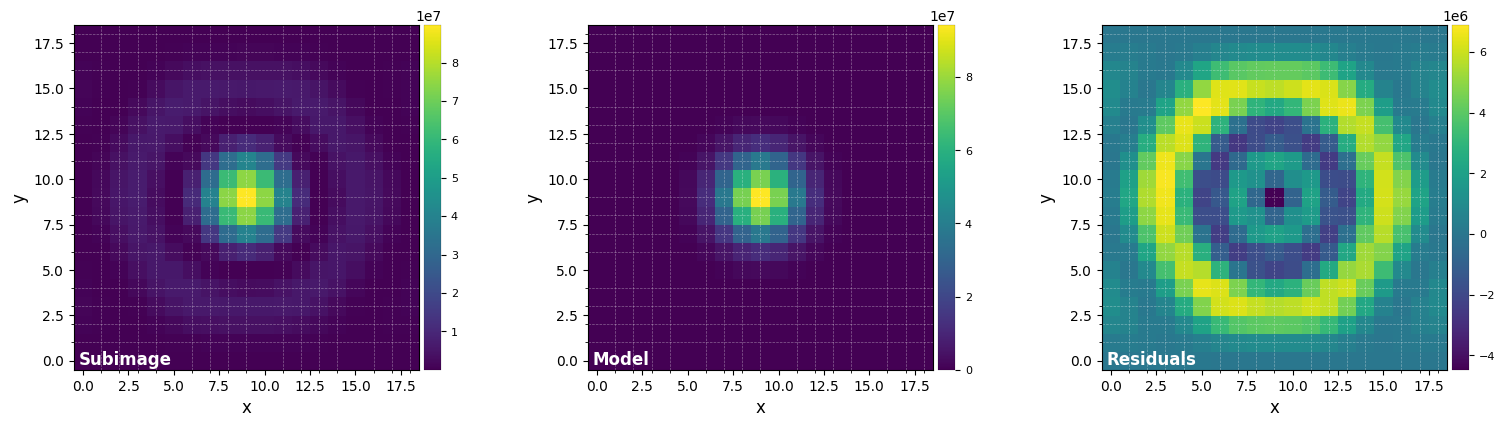

FWHM_y = 3.4895315787917
FWHM_x = 3.4907513625827713 

centroid y = 9.007994885329637
centroid x = 9.004548062695022
centroid y subim = 9.007994885329637
centroid x subim = 9.004548062695022 

amplitude = 94303608.56117567
theta = 314.531224653593

Mean FWHM: 3.490
Flux in 1xFWHM aperture: 638611963.628
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 20:05:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4901414706872353, # BRANCHES = 3, SIGMA = 5, STARPHOT = 638611963.6282443
Finished the throughput calculation
Running time:  0:05:57.702520
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taking t

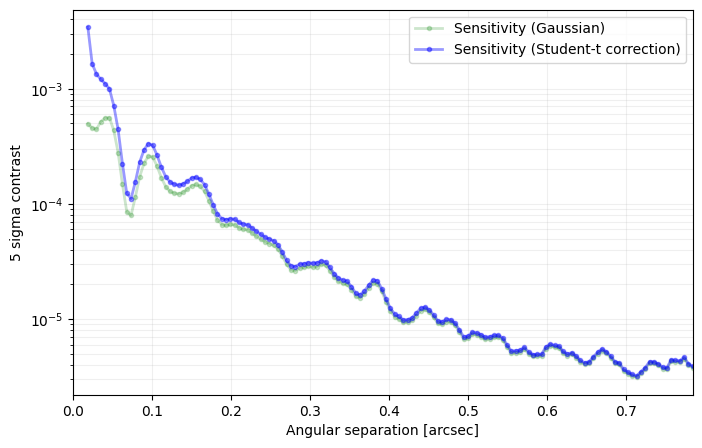

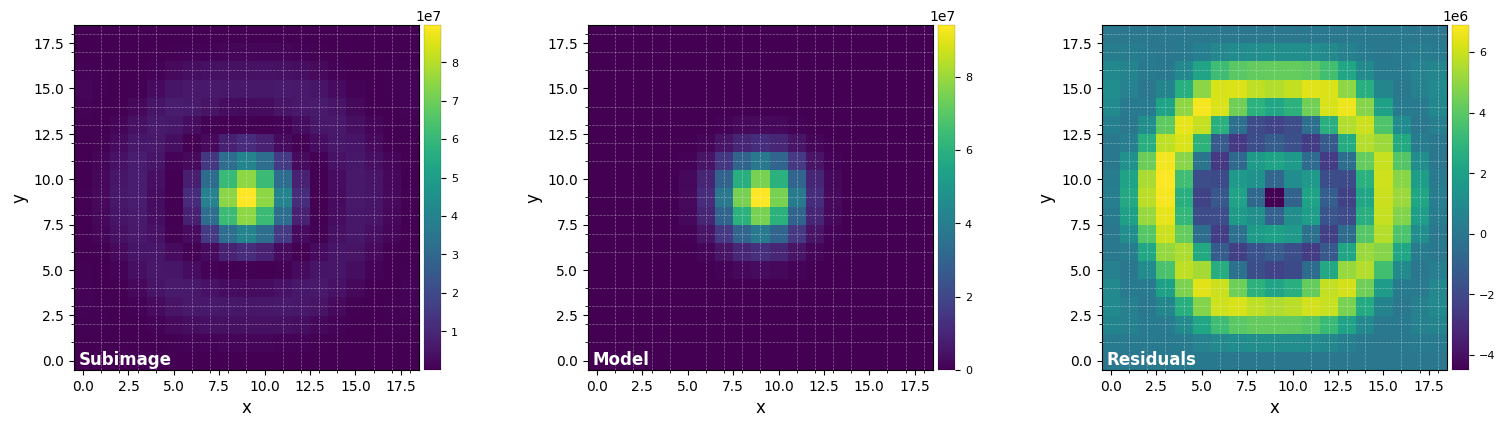

FWHM_y = 3.5147361868239
FWHM_x = 3.4936446794433818 

centroid y = 8.995970860558119
centroid x = 9.007401465050314
centroid y subim = 8.995970860558119
centroid x subim = 9.007401465050314 

amplitude = 94200224.37989965
theta = -21.743131951156034

Mean FWHM: 3.504
Flux in 1xFWHM aperture: 642752055.168
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 20:13:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.504190433133641, # BRANCHES = 3, SIGMA = 5, STARPHOT = 642752055.1682943
Finished the throughput calculation
Running time:  0:06:17.265739
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taking

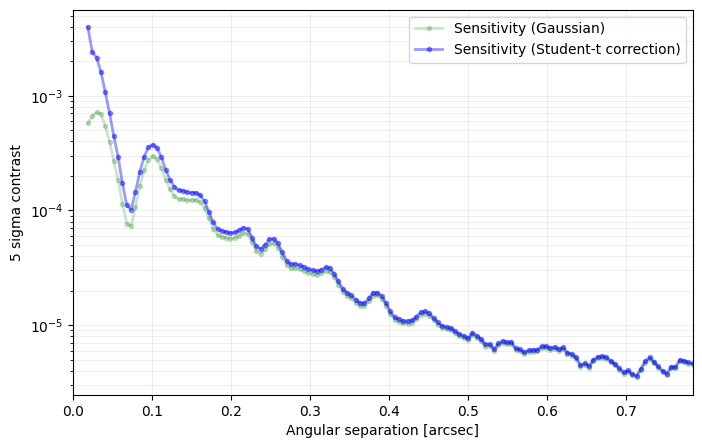

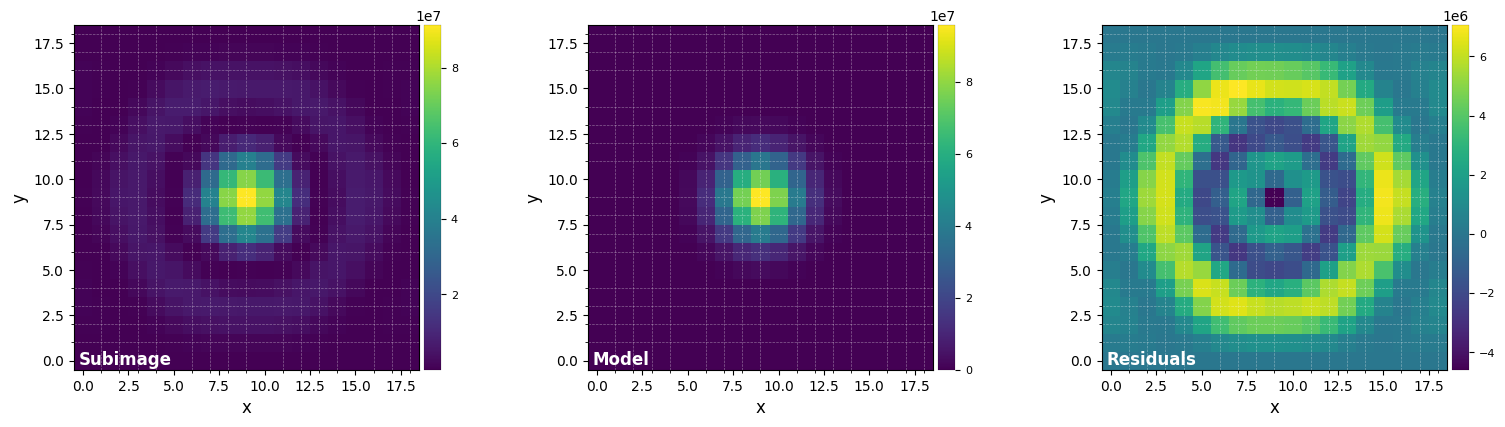

FWHM_y = 3.495396192888877
FWHM_x = 3.5138692550422843 

centroid y = 8.971810132480323
centroid x = 9.02260685935429
centroid y subim = 8.971810132480323
centroid x subim = 9.02260685935429 

amplitude = 95921888.51930839
theta = 17.02498044237753

Mean FWHM: 3.505
Flux in 1xFWHM aperture: 654489290.132
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 20:21:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.504632723965581, # BRANCHES = 3, SIGMA = 5, STARPHOT = 654489290.1316442
Finished the throughput calculation
Running time:  0:06:07.348319
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taking t

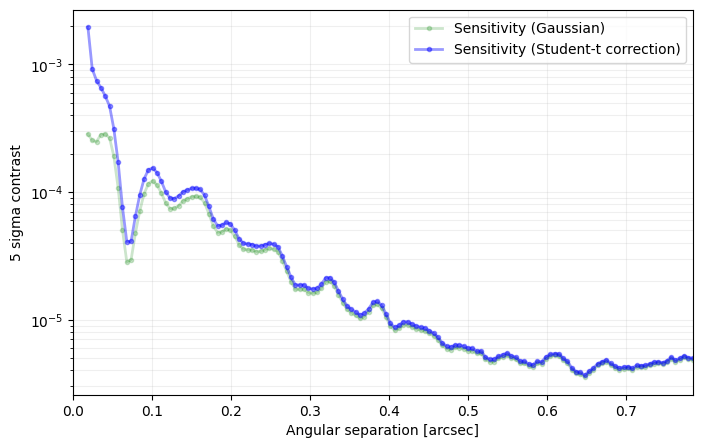

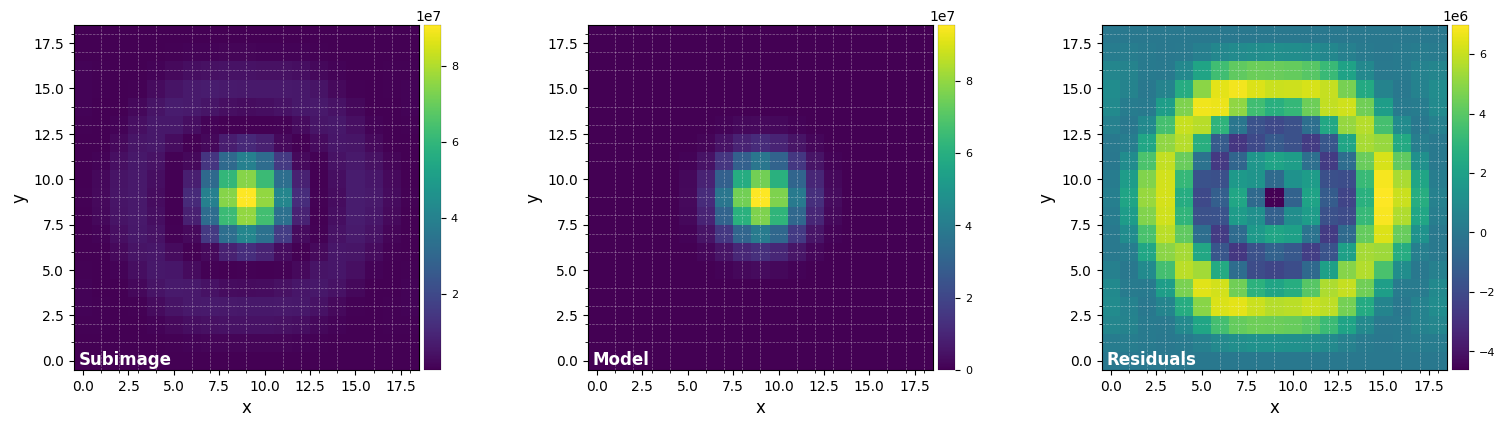

FWHM_y = 3.4960436427115233
FWHM_x = 3.491417059416141 

centroid y = 8.968376949087363
centroid x = 9.028946083747268
centroid y subim = 8.968376949087363
centroid x subim = 9.028946083747268 

amplitude = 95549355.95200911
theta = -16.854484608934985

Mean FWHM: 3.494
Flux in 1xFWHM aperture: 647971115.045
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 20:30:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4937303510638325, # BRANCHES = 3, SIGMA = 5, STARPHOT = 647971115.0447446
Finished the throughput calculation
Running time:  0:06:14.243875
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by tak

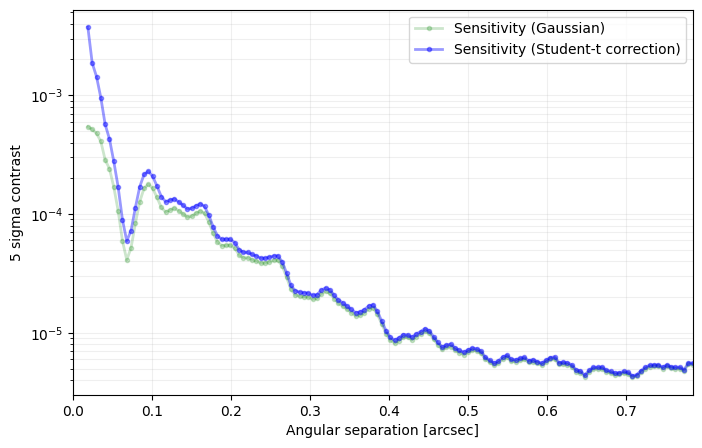

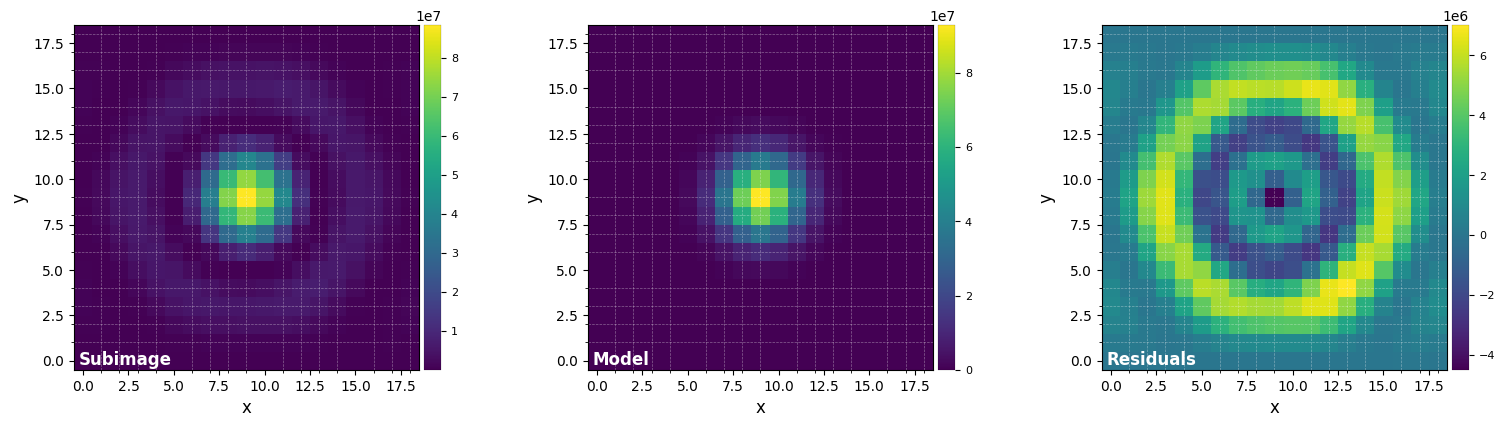

FWHM_y = 3.4993406798122906
FWHM_x = 3.484149719501638 

centroid y = 9.030004374472515
centroid x = 9.043460046175166
centroid y subim = 9.030004374472515
centroid x subim = 9.043460046175166 

amplitude = 93015373.51715831
theta = -939.3144284257254

Mean FWHM: 3.492
Flux in 1xFWHM aperture: 630292468.748
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 20:38:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.4917451996569646, # BRANCHES = 3, SIGMA = 5, STARPHOT = 630292468.7476003
Finished the throughput calculation
Running time:  0:06:25.670661
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
FITS HDU-0 data successfully loaded. Data shape: (6000, 293, 293)
FITS HDU-0 data successfully loaded. Data shape: (293, 293)
Cube temporally subsampled by taki

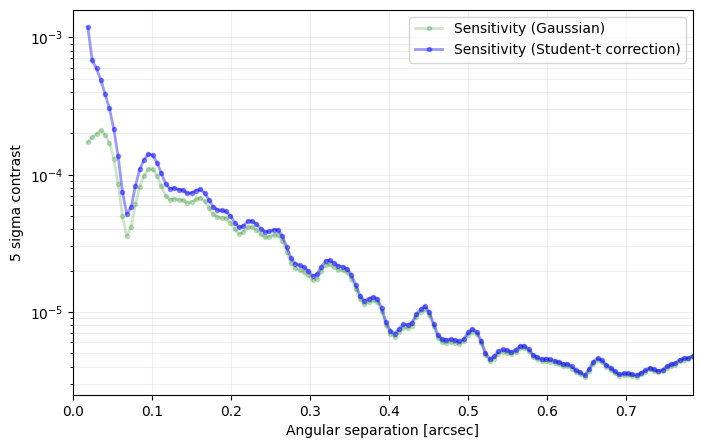

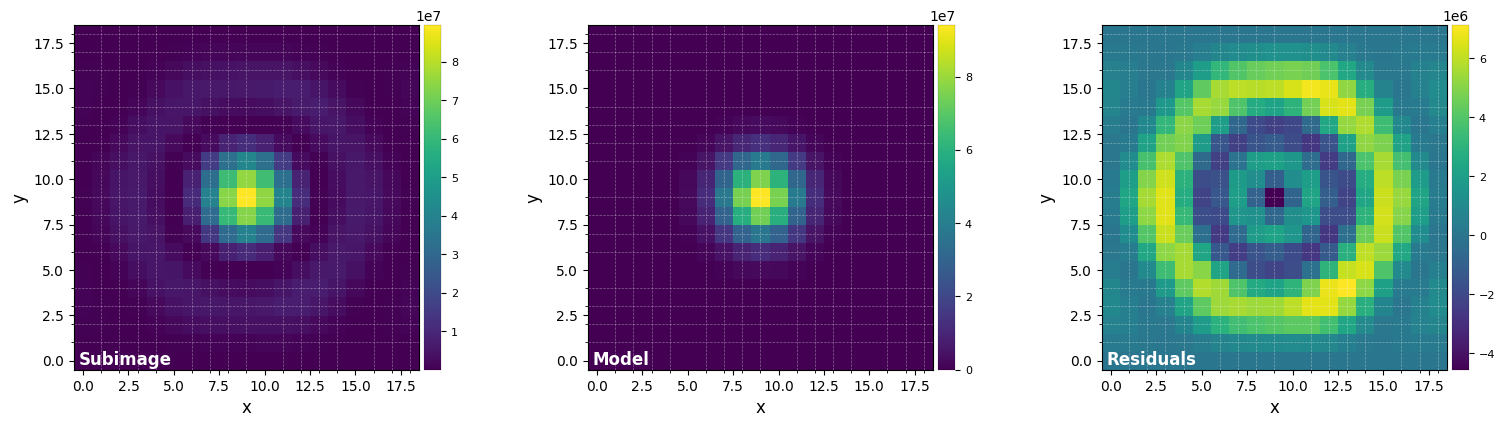

FWHM_y = 3.5005910157512905
FWHM_x = 3.4949576439253818 

centroid y = 9.028970055841148
centroid x = 9.00926627539722
centroid y subim = 9.028970055841148
centroid x subim = 9.00926627539722 

amplitude = 94212111.1613018
theta = 4.954443802703337

Mean FWHM: 3.498
Flux in 1xFWHM aperture: 640483653.378
Cube temporally subsampled by taking the mean of every 60 frames
New shape: (100, 293, 293)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-15 20:46:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 3.497774329838336, # BRANCHES = 3, SIGMA = 5, STARPHOT = 640483653.3776765
Finished the throughput calculation
Running time:  0:06:23.868521
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


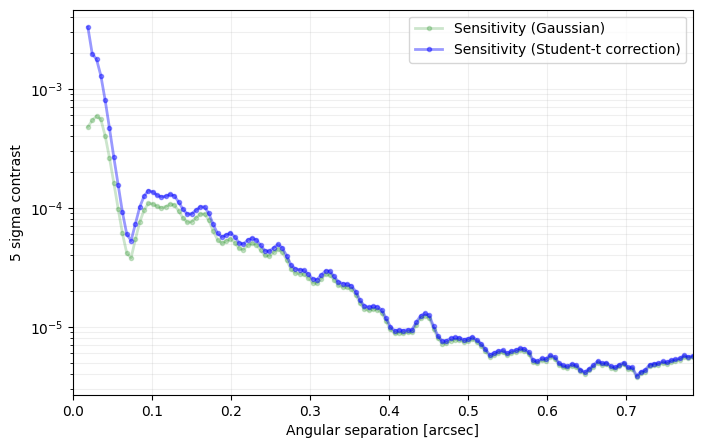

In [23]:
from vip_hci.preproc import cube_detect_badfr_correlation
from vip_hci.preproc.subsampling import cube_subsample
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version
from vip_hci.fits import open_fits
from astropy.utils.data import download_file
from vip_hci.psfsub import pca
from vip_hci.config.paramenum import SvdMode
from vip_hci.fm import normalize_psf
from vip_hci.metrics import contrast_curve
import pandas as pd

mags = [7.0,7.5,8.0,8.5]
seeing = ['smedian', 'sQ2', 'sQ3']
versions = ['v1', 'v2']
item = 0

for mag in mags:
    for see in seeing:
        for ver in versions:
            item += 1
            f1 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/onaxis_PSF_L_CVC_with_bkg_{}_z30d_Kmag{}_{}.fits".format(see, mag, ver)
            f2 = "C:/Users/bryce/Downloads/METIS_star_hopping/METIS_star_hopping/offaxis_PSF_L_CVC_with_bkg_{}_z30d_Kmag{}_{}.fits".format(see, mag,ver)

            cube = open_fits(f1)
            psf = open_fits(f2)
            
            good_list = []
            prog = 0
            # find the mostly correlated images from the 2400 image reference cube, not sure if this is the best way to do this as the numbers dont vastly change, feel like we should either pick subsampling or getting the best correlation
            for frame in cube_subsample(cube,60):
                good_idx_p, bad_idx_p = cube_detect_badfr_correlation(cube_ref, frame_ref=frame, 
                                                                    crop_size=31, dist='pearson', percentile=99, 
                                                                    threshold=None, plot=False, verbose=False)
                good_list += list(good_idx_p)
                prog += 1
                print('Item {}/24 Finished Correlation {}/100'.format(item, prog))
            good_list = list(dict.fromkeys(good_list))
            print(len(good_list))

            cube_ref_trim = np.zeros(shape = (len(good_list), 293, 293))
            for i in range(len(good_list)):
                cube_ref_trim[i] = cube_ref[good_list[i]]
                
            psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

            cube_sampled = cube_subsample(cube,60)
            angs = np.zeros(shape = 100) # should be the same length as cube_sampled
            starphot = float(flux)

            pxscale = 0.00547 # arcseconds/pixel
            cc_rdi = contrast_curve(cube_sampled, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=10, cube_ref=cube_ref_trim, svd_mode = SvdMode.RANDSVD)

            cc_rdi.to_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/{}_{}_{}_sci100_ref2400_cor.pkl'.format(mag, ver, see)) # saving format [mag]_[version]_[seeing]_sci[science sample length]_ref[reference sample length]_[reference cube correlated or not]

Index(['sensitivity_gaussian', 'sensitivity_student', 'throughput', 'distance',
       'distance_arcsec', 'noise', 'residual_level', 'sigma corr'],
      dtype='object')


Text(0.5, 1.0, 'Contrast curves for 8.5 mag, v2, smedian')

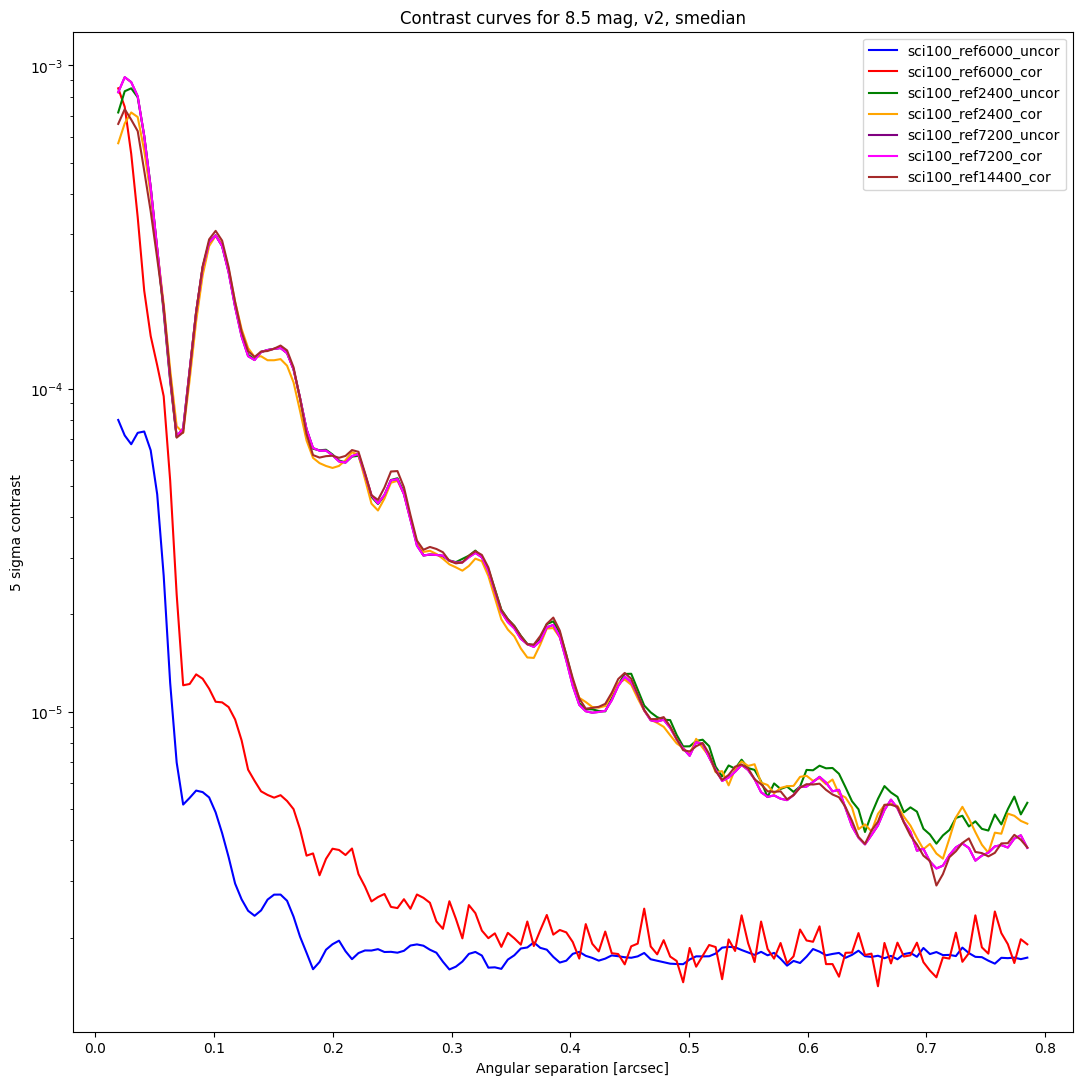

In [6]:
uncor_6000 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_smedian_sci100_ref6000_uncor.pkl')
cor_6000 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_smedian_sci100_ref6000_cor.pkl')
uncor_2400 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_smedian_sci100_ref2400_uncor.pkl')
cor_2400 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_smedian_sci100_ref2400_cor.pkl')
uncor_7200 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_smedian_sci100_ref7200_uncor.pkl')
cor_7200 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_smedian_sci100_ref7200_cor.pkl')
cor_14400 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.5_v2_smedian_sci100_ref14400_cor.pkl')

print(uncor_6000.keys())
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
ax.plot(uncor_6000.distance_arcsec, uncor_6000.sensitivity_gaussian, color = 'blue', label = 'sci100_ref6000_uncor')
ax.plot(cor_6000.distance_arcsec, cor_6000.sensitivity_gaussian, color = 'red', label = 'sci100_ref6000_cor')
ax.plot(uncor_2400.distance_arcsec, uncor_2400.sensitivity_gaussian, color = 'green', label = 'sci100_ref2400_uncor')
ax.plot(cor_2400.distance_arcsec, cor_2400.sensitivity_gaussian, color = 'orange', label = 'sci100_ref2400_cor')
ax.plot(uncor_7200.distance_arcsec, uncor_7200.sensitivity_gaussian, color = 'purple', label = 'sci100_ref7200_uncor')
ax.plot(uncor_7200.distance_arcsec, uncor_7200.sensitivity_gaussian, color = 'magenta', label = 'sci100_ref7200_cor')
ax.plot(cor_14400.distance_arcsec, cor_14400.sensitivity_gaussian, color = 'brown', label = 'sci100_ref14400_cor')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Angular separation [arcsec]')
ax.set_ylabel('5 sigma contrast')
ax.set_title('Contrast curves for 8.5 mag, v2, smedian')

Text(0.5, 1.0, 'Contrast curves for 8.0 mag, v2, smedian')

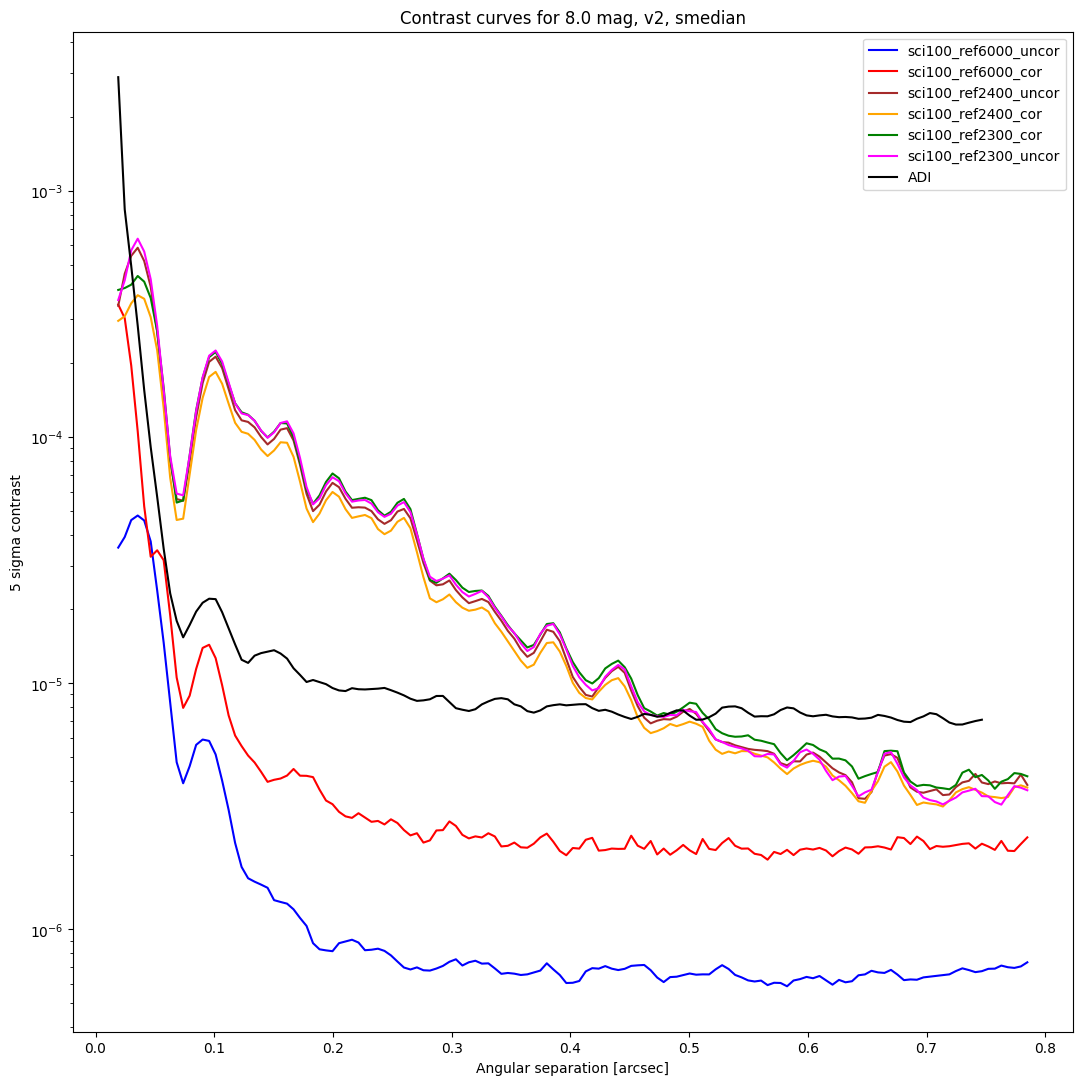

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
cor_2400 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.0_v2_smedian_sci100_ref2400_cor.pkl')
cor_2300 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.0_v2_smedian_sci100_ref2300_cor.pkl')
uncor_2300 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.0_v2_smedian_sci100_ref2300_uncor.pkl')
uncor_2400 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.0_v2_smedian_sci100_ref2400_uncor.pkl')
data = fits.getdata("C:/Users/bryce/High_Contrast_Imaging/METIS_2023/exeter/fits/cc_adi_bckg1_mag8_L_CVC_exeter_all_effects.fits", ext=0)
uncor_6000 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.0_v2_smedian_sci100_ref6000_uncor.pkl')
cor_6000 = pd.read_pickle('C:/Users/bryce/High_Contrast_Imaging/METIS_2024/VIP/8.0_v2_smedian_sci100_ref6000_cor.pkl')

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
ax.plot(uncor_6000.distance_arcsec, uncor_6000.sensitivity_gaussian, color = 'blue', label = 'sci100_ref6000_uncor')
ax.plot(cor_6000.distance_arcsec, cor_6000.sensitivity_gaussian, color = 'red', label = 'sci100_ref6000_cor')
ax.plot(uncor_2400.distance_arcsec, uncor_2400.sensitivity_gaussian, color = 'brown', label = 'sci100_ref2400_uncor')
ax.plot(cor_2400.distance_arcsec, cor_2400.sensitivity_gaussian, color = 'orange', label = 'sci100_ref2400_cor')
ax.plot(cor_2300.distance_arcsec, cor_2300.sensitivity_gaussian, color = 'green', label = 'sci100_ref2300_cor')
ax.plot(uncor_2300.distance_arcsec, uncor_2300.sensitivity_gaussian, color = 'magenta', label = 'sci100_ref2300_uncor')
ax.plot(data[0,:], data[1,:], color = 'black', label = 'ADI')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Angular separation [arcsec]')
ax.set_ylabel('5 sigma contrast')
ax.set_title('Contrast curves for 8.0 mag, v2, smedian')
